# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: med


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:20:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:20:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:20:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:20:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:20:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:20:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.8044976182806185
Average Accuracy: 0.7421213264291348
Average Precision: 0.7020729193448716
Average Recall: 0.5992385218365062


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:20:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:20:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:21:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:21:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:21:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.7990909237953108
Average Accuracy: 0.7396179829223964
Average Precision: 0.697873084513778
Average Recall: 0.5971780515117582


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))


[0]	validation_0-logloss:0.66586


[1]	validation_0-logloss:0.66291


[2]	validation_0-logloss:0.66065


[3]	validation_0-logloss:0.65851


[4]	validation_0-logloss:0.65588


[5]	validation_0-logloss:0.65333


[6]	validation_0-logloss:0.65099


[7]	validation_0-logloss:0.64883


[8]	validation_0-logloss:0.64617


[9]	validation_0-logloss:0.64351


[10]	validation_0-logloss:0.64086


[11]	validation_0-logloss:0.63867


[12]	validation_0-logloss:0.63671


[13]	validation_0-logloss:0.63446


[14]	validation_0-logloss:0.63236


[15]	validation_0-logloss:0.62988


[16]	validation_0-logloss:0.62743


[17]	validation_0-logloss:0.62530


[18]	validation_0-logloss:0.62296


[19]	validation_0-logloss:0.62082


[20]	validation_0-logloss:0.61899


[21]	validation_0-logloss:0.61761


[22]	validation_0-logloss:0.61582


[23]	validation_0-logloss:0.61402


[24]	validation_0-logloss:0.61220


[25]	validation_0-logloss:0.60989


[26]	validation_0-logloss:0.60861


[27]	validation_0-logloss:0.60628


[28]	validation_0-logloss:0.60481


[29]	validation_0-logloss:0.60271


[30]	validation_0-logloss:0.60136


[31]	validation_0-logloss:0.60014


[32]	validation_0-logloss:0.59930


[33]	validation_0-logloss:0.59755


[34]	validation_0-logloss:0.59582


[35]	validation_0-logloss:0.59426


[36]	validation_0-logloss:0.59237


[37]	validation_0-logloss:0.59087


[38]	validation_0-logloss:0.58959


[39]	validation_0-logloss:0.58854


[40]	validation_0-logloss:0.58749


[41]	validation_0-logloss:0.58683


[42]	validation_0-logloss:0.58551


[43]	validation_0-logloss:0.58420


[44]	validation_0-logloss:0.58286


[45]	validation_0-logloss:0.58151


[46]	validation_0-logloss:0.58017


[47]	validation_0-logloss:0.57899


[48]	validation_0-logloss:0.57754


[49]	validation_0-logloss:0.57600


[50]	validation_0-logloss:0.57437


[51]	validation_0-logloss:0.57288


[52]	validation_0-logloss:0.57199


[53]	validation_0-logloss:0.57082


[54]	validation_0-logloss:0.56953


[55]	validation_0-logloss:0.56822


[56]	validation_0-logloss:0.56661


[57]	validation_0-logloss:0.56595


[58]	validation_0-logloss:0.56478


[59]	validation_0-logloss:0.56370


[60]	validation_0-logloss:0.56279


[61]	validation_0-logloss:0.56177


[62]	validation_0-logloss:0.56043


[63]	validation_0-logloss:0.55888


[64]	validation_0-logloss:0.55795


[65]	validation_0-logloss:0.55682


[66]	validation_0-logloss:0.55569


[67]	validation_0-logloss:0.55501


[68]	validation_0-logloss:0.55417


[69]	validation_0-logloss:0.55351


[70]	validation_0-logloss:0.55238


[71]	validation_0-logloss:0.55148


[72]	validation_0-logloss:0.55079


[73]	validation_0-logloss:0.54992


[74]	validation_0-logloss:0.54881


[75]	validation_0-logloss:0.54782


[76]	validation_0-logloss:0.54705


[77]	validation_0-logloss:0.54617


[78]	validation_0-logloss:0.54556


[79]	validation_0-logloss:0.54478


[80]	validation_0-logloss:0.54415


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:22:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[81]	validation_0-logloss:0.54357


[82]	validation_0-logloss:0.54235


[83]	validation_0-logloss:0.54173


[84]	validation_0-logloss:0.54088


[85]	validation_0-logloss:0.54033


[86]	validation_0-logloss:0.53989


[87]	validation_0-logloss:0.53932


[88]	validation_0-logloss:0.53855


[89]	validation_0-logloss:0.53784


[90]	validation_0-logloss:0.53678


[91]	validation_0-logloss:0.53652


[92]	validation_0-logloss:0.53597


[93]	validation_0-logloss:0.53534


[94]	validation_0-logloss:0.53433


[95]	validation_0-logloss:0.53349


[96]	validation_0-logloss:0.53237


[97]	validation_0-logloss:0.53177


[98]	validation_0-logloss:0.53119


[99]	validation_0-logloss:0.53070


[100]	validation_0-logloss:0.53033


[101]	validation_0-logloss:0.53002


[102]	validation_0-logloss:0.52934


[103]	validation_0-logloss:0.52869


[104]	validation_0-logloss:0.52777


[105]	validation_0-logloss:0.52732


[106]	validation_0-logloss:0.52651


[107]	validation_0-logloss:0.52584


[108]	validation_0-logloss:0.52531


[109]	validation_0-logloss:0.52466


[110]	validation_0-logloss:0.52436


[111]	validation_0-logloss:0.52382


[112]	validation_0-logloss:0.52296


[113]	validation_0-logloss:0.52222


[114]	validation_0-logloss:0.52170


[115]	validation_0-logloss:0.52124


[116]	validation_0-logloss:0.52104


[117]	validation_0-logloss:0.52086


[118]	validation_0-logloss:0.52057


[119]	validation_0-logloss:0.52028


[120]	validation_0-logloss:0.51977


[121]	validation_0-logloss:0.51943


[122]	validation_0-logloss:0.51906


[123]	validation_0-logloss:0.51855


[124]	validation_0-logloss:0.51789


[125]	validation_0-logloss:0.51735


[126]	validation_0-logloss:0.51680


[127]	validation_0-logloss:0.51625


[128]	validation_0-logloss:0.51588


[129]	validation_0-logloss:0.51561


[130]	validation_0-logloss:0.51531


[131]	validation_0-logloss:0.51482


[132]	validation_0-logloss:0.51473


[133]	validation_0-logloss:0.51405


[134]	validation_0-logloss:0.51367


[135]	validation_0-logloss:0.51322


[136]	validation_0-logloss:0.51298


[137]	validation_0-logloss:0.51272


[138]	validation_0-logloss:0.51258


[139]	validation_0-logloss:0.51190


[140]	validation_0-logloss:0.51163


[141]	validation_0-logloss:0.51112


[142]	validation_0-logloss:0.51085


[143]	validation_0-logloss:0.51048


[144]	validation_0-logloss:0.51035


[145]	validation_0-logloss:0.50984


[146]	validation_0-logloss:0.50975


[147]	validation_0-logloss:0.50902


[148]	validation_0-logloss:0.50879


[149]	validation_0-logloss:0.50822


[150]	validation_0-logloss:0.50781


[151]	validation_0-logloss:0.50769


[152]	validation_0-logloss:0.50719


[153]	validation_0-logloss:0.50683


[154]	validation_0-logloss:0.50636


[155]	validation_0-logloss:0.50622


[156]	validation_0-logloss:0.50594


[157]	validation_0-logloss:0.50551


[158]	validation_0-logloss:0.50516


[159]	validation_0-logloss:0.50452


[160]	validation_0-logloss:0.50395


[161]	validation_0-logloss:0.50386


[162]	validation_0-logloss:0.50379


[163]	validation_0-logloss:0.50324


[164]	validation_0-logloss:0.50270


[165]	validation_0-logloss:0.50284


[166]	validation_0-logloss:0.50247


[167]	validation_0-logloss:0.50226


[168]	validation_0-logloss:0.50174


[169]	validation_0-logloss:0.50148


[170]	validation_0-logloss:0.50128


[171]	validation_0-logloss:0.50104


[172]	validation_0-logloss:0.50089


[173]	validation_0-logloss:0.50060


[174]	validation_0-logloss:0.50021


[175]	validation_0-logloss:0.50005


[176]	validation_0-logloss:0.49980


[177]	validation_0-logloss:0.49937


[178]	validation_0-logloss:0.49922


[179]	validation_0-logloss:0.49877


[180]	validation_0-logloss:0.49850

[181]	validation_0-logloss:0.49859


[182]	validation_0-logloss:0.49839


[183]	validation_0-logloss:0.49849


[184]	validation_0-logloss:0.49830


[185]	validation_0-logloss:0.49810


[186]	validation_0-logloss:0.49739


[187]	validation_0-logloss:0.49722


[188]	validation_0-logloss:0.49680


[189]	validation_0-logloss:0.49675


[190]	validation_0-logloss:0.49655


[191]	validation_0-logloss:0.49628


[192]	validation_0-logloss:0.49631


[193]	validation_0-logloss:0.49620


[194]	validation_0-logloss:0.49582


[195]	validation_0-logloss:0.49549


[196]	validation_0-logloss:0.49533


[197]	validation_0-logloss:0.49527


[198]	validation_0-logloss:0.49515


[199]	validation_0-logloss:0.49507


[200]	validation_0-logloss:0.49483


[201]	validation_0-logloss:0.49455


[202]	validation_0-logloss:0.49456


[203]	validation_0-logloss:0.49473


[204]	validation_0-logloss:0.49435


[205]	validation_0-logloss:0.49469


[206]	validation_0-logloss:0.49458


[207]	validation_0-logloss:0.49489


[208]	validation_0-logloss:0.49463


[209]	validation_0-logloss:0.49437


[210]	validation_0-logloss:0.49435


[211]	validation_0-logloss:0.49462


[212]	validation_0-logloss:0.49458


[213]	validation_0-logloss:0.49446


[214]	validation_0-logloss:0.49435


[215]	validation_0-logloss:0.49407


[216]	validation_0-logloss:0.49402


[217]	validation_0-logloss:0.49374


[218]	validation_0-logloss:0.49359


[219]	validation_0-logloss:0.49352


[220]	validation_0-logloss:0.49382


[221]	validation_0-logloss:0.49367

[222]	validation_0-logloss:0.49341

[223]	validation_0-logloss:0.49292


[224]	validation_0-logloss:0.49262


[225]	validation_0-logloss:0.49257


[226]	validation_0-logloss:0.49248


[227]	validation_0-logloss:0.49236


[228]	validation_0-logloss:0.49214


[229]	validation_0-logloss:0.49216


[230]	validation_0-logloss:0.49197


[231]	validation_0-logloss:0.49226


[232]	validation_0-logloss:0.49209


[233]	validation_0-logloss:0.49214


[234]	validation_0-logloss:0.49201


[235]	validation_0-logloss:0.49193


[236]	validation_0-logloss:0.49184


[237]	validation_0-logloss:0.49199


[238]	validation_0-logloss:0.49201


[239]	validation_0-logloss:0.49220


[240]	validation_0-logloss:0.49213


[241]	validation_0-logloss:0.49209


[242]	validation_0-logloss:0.49199


[243]	validation_0-logloss:0.49216


[244]	validation_0-logloss:0.49200


[245]	validation_0-logloss:0.49212


[0]	validation_0-logloss:0.66814


[1]	validation_0-logloss:0.66591


[2]	validation_0-logloss:0.66323


[3]	validation_0-logloss:0.66094


[4]	validation_0-logloss:0.65858


[5]	validation_0-logloss:0.65587


[6]	validation_0-logloss:0.65253


[7]	validation_0-logloss:0.65032


[8]	validation_0-logloss:0.64811


[9]	validation_0-logloss:0.64619


[10]	validation_0-logloss:0.64461


[11]	validation_0-logloss:0.64227


[12]	validation_0-logloss:0.64008


[13]	validation_0-logloss:0.63805


[14]	validation_0-logloss:0.63557


[15]	validation_0-logloss:0.63378


[16]	validation_0-logloss:0.63237


[17]	validation_0-logloss:0.63060


[18]	validation_0-logloss:0.62866


[19]	validation_0-logloss:0.62642


[20]	validation_0-logloss:0.62483


[21]	validation_0-logloss:0.62285


[22]	validation_0-logloss:0.62124


[23]	validation_0-logloss:0.61948


[24]	validation_0-logloss:0.61747


[25]	validation_0-logloss:0.61601


[26]	validation_0-logloss:0.61465


[27]	validation_0-logloss:0.61300


[28]	validation_0-logloss:0.61170


[29]	validation_0-logloss:0.60989


[30]	validation_0-logloss:0.60875


[31]	validation_0-logloss:0.60746


[32]	validation_0-logloss:0.60606


[33]	validation_0-logloss:0.60486


[34]	validation_0-logloss:0.60316


[35]	validation_0-logloss:0.60113


[36]	validation_0-logloss:0.59977


[37]	validation_0-logloss:0.59827


[38]	validation_0-logloss:0.59698


[39]	validation_0-logloss:0.59572


[40]	validation_0-logloss:0.59473


[41]	validation_0-logloss:0.59385


[42]	validation_0-logloss:0.59269


[43]	validation_0-logloss:0.59138


[44]	validation_0-logloss:0.58966


[45]	validation_0-logloss:0.58832


[46]	validation_0-logloss:0.58723


[47]	validation_0-logloss:0.58563


[48]	validation_0-logloss:0.58444


[49]	validation_0-logloss:0.58321


[50]	validation_0-logloss:0.58200


[51]	validation_0-logloss:0.58090


[52]	validation_0-logloss:0.58023


[53]	validation_0-logloss:0.57927


[54]	validation_0-logloss:0.57757


[55]	validation_0-logloss:0.57670


[56]	validation_0-logloss:0.57506


[57]	validation_0-logloss:0.57422


[58]	validation_0-logloss:0.57338


[59]	validation_0-logloss:0.57230


[60]	validation_0-logloss:0.57133


[61]	validation_0-logloss:0.57069


[62]	validation_0-logloss:0.56979


[63]	validation_0-logloss:0.56876


[64]	validation_0-logloss:0.56805


[65]	validation_0-logloss:0.56717


[66]	validation_0-logloss:0.56602


[67]	validation_0-logloss:0.56495


[68]	validation_0-logloss:0.56393


[69]	validation_0-logloss:0.56288


[70]	validation_0-logloss:0.56183


[71]	validation_0-logloss:0.56090


[72]	validation_0-logloss:0.56005


[73]	validation_0-logloss:0.55905


[74]	validation_0-logloss:0.55773


[75]	validation_0-logloss:0.55681


[76]	validation_0-logloss:0.55635


[77]	validation_0-logloss:0.55564


[78]	validation_0-logloss:0.55486


[79]	validation_0-logloss:0.55416


[80]	validation_0-logloss:0.55359


[81]	validation_0-logloss:0.55322


[82]	validation_0-logloss:0.55263


[83]	validation_0-logloss:0.55122


[84]	validation_0-logloss:0.55014


[85]	validation_0-logloss:0.54951


[86]	validation_0-logloss:0.54894


[87]	validation_0-logloss:0.54780


[88]	validation_0-logloss:0.54697


[89]	validation_0-logloss:0.54636


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:22:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[90]	validation_0-logloss:0.54545


[91]	validation_0-logloss:0.54518


[92]	validation_0-logloss:0.54473


[93]	validation_0-logloss:0.54387


[94]	validation_0-logloss:0.54290


[95]	validation_0-logloss:0.54266


[96]	validation_0-logloss:0.54223


[97]	validation_0-logloss:0.54186


[98]	validation_0-logloss:0.54137


[99]	validation_0-logloss:0.54059


[100]	validation_0-logloss:0.53991


[101]	validation_0-logloss:0.53950


[102]	validation_0-logloss:0.53916


[103]	validation_0-logloss:0.53857


[104]	validation_0-logloss:0.53770


[105]	validation_0-logloss:0.53695


[106]	validation_0-logloss:0.53665


[107]	validation_0-logloss:0.53644


[108]	validation_0-logloss:0.53603


[109]	validation_0-logloss:0.53515


[110]	validation_0-logloss:0.53478


[111]	validation_0-logloss:0.53372


[112]	validation_0-logloss:0.53291


[113]	validation_0-logloss:0.53220


[114]	validation_0-logloss:0.53152


[115]	validation_0-logloss:0.53124


[116]	validation_0-logloss:0.53094


[117]	validation_0-logloss:0.53059


[118]	validation_0-logloss:0.53021


[119]	validation_0-logloss:0.52995


[120]	validation_0-logloss:0.52944


[121]	validation_0-logloss:0.52898


[122]	validation_0-logloss:0.52781


[123]	validation_0-logloss:0.52765


[124]	validation_0-logloss:0.52729


[125]	validation_0-logloss:0.52700


[126]	validation_0-logloss:0.52643


[127]	validation_0-logloss:0.52588


[128]	validation_0-logloss:0.52576


[129]	validation_0-logloss:0.52566


[130]	validation_0-logloss:0.52536


[131]	validation_0-logloss:0.52506


[132]	validation_0-logloss:0.52417


[133]	validation_0-logloss:0.52368


[134]	validation_0-logloss:0.52350


[135]	validation_0-logloss:0.52325


[136]	validation_0-logloss:0.52301


[137]	validation_0-logloss:0.52275


[138]	validation_0-logloss:0.52237


[139]	validation_0-logloss:0.52181


[140]	validation_0-logloss:0.52146


[141]	validation_0-logloss:0.52106


[142]	validation_0-logloss:0.52023


[143]	validation_0-logloss:0.52010


[144]	validation_0-logloss:0.51976


[145]	validation_0-logloss:0.51922


[146]	validation_0-logloss:0.51879


[147]	validation_0-logloss:0.51859


[148]	validation_0-logloss:0.51816


[149]	validation_0-logloss:0.51788


[150]	validation_0-logloss:0.51746


[151]	validation_0-logloss:0.51708


[152]	validation_0-logloss:0.51700


[153]	validation_0-logloss:0.51668


[154]	validation_0-logloss:0.51596


[155]	validation_0-logloss:0.51571


[156]	validation_0-logloss:0.51565


[157]	validation_0-logloss:0.51537


[158]	validation_0-logloss:0.51515


[159]	validation_0-logloss:0.51472


[160]	validation_0-logloss:0.51490


[161]	validation_0-logloss:0.51431


[162]	validation_0-logloss:0.51429


[163]	validation_0-logloss:0.51378


[164]	validation_0-logloss:0.51331


[165]	validation_0-logloss:0.51306


[166]	validation_0-logloss:0.51264


[167]	validation_0-logloss:0.51247


[168]	validation_0-logloss:0.51227


[169]	validation_0-logloss:0.51193


[170]	validation_0-logloss:0.51181


[171]	validation_0-logloss:0.51169


[172]	validation_0-logloss:0.51121


[173]	validation_0-logloss:0.51082


[174]	validation_0-logloss:0.51069


[175]	validation_0-logloss:0.51056


[176]	validation_0-logloss:0.51030


[177]	validation_0-logloss:0.51023


[178]	validation_0-logloss:0.51009


[179]	validation_0-logloss:0.50983


[180]	validation_0-logloss:0.50974


[181]	validation_0-logloss:0.50937


[182]	validation_0-logloss:0.50919


[183]	validation_0-logloss:0.50872


[184]	validation_0-logloss:0.50827


[185]	validation_0-logloss:0.50836


[186]	validation_0-logloss:0.50806


[187]	validation_0-logloss:0.50797


[188]	validation_0-logloss:0.50796


[189]	validation_0-logloss:0.50784


[190]	validation_0-logloss:0.50761


[191]	validation_0-logloss:0.50731


[192]	validation_0-logloss:0.50704


[193]	validation_0-logloss:0.50708


[194]	validation_0-logloss:0.50674


[195]	validation_0-logloss:0.50641


[196]	validation_0-logloss:0.50638


[197]	validation_0-logloss:0.50630


[198]	validation_0-logloss:0.50624


[199]	validation_0-logloss:0.50591


[200]	validation_0-logloss:0.50570


[201]	validation_0-logloss:0.50541


[202]	validation_0-logloss:0.50529


[203]	validation_0-logloss:0.50515


[204]	validation_0-logloss:0.50495


[205]	validation_0-logloss:0.50477


[206]	validation_0-logloss:0.50462


[207]	validation_0-logloss:0.50423


[208]	validation_0-logloss:0.50415


[209]	validation_0-logloss:0.50398


[210]	validation_0-logloss:0.50378


[211]	validation_0-logloss:0.50375


[212]	validation_0-logloss:0.50356


[213]	validation_0-logloss:0.50320

[214]	validation_0-logloss:0.50281


[215]	validation_0-logloss:0.50259


[216]	validation_0-logloss:0.50248


[217]	validation_0-logloss:0.50239


[218]	validation_0-logloss:0.50225


[219]	validation_0-logloss:0.50217


[220]	validation_0-logloss:0.50237


[221]	validation_0-logloss:0.50238


[222]	validation_0-logloss:0.50224


[223]	validation_0-logloss:0.50188


[224]	validation_0-logloss:0.50171


[225]	validation_0-logloss:0.50195


[226]	validation_0-logloss:0.50183


[227]	validation_0-logloss:0.50176


[228]	validation_0-logloss:0.50177


[229]	validation_0-logloss:0.50122


[230]	validation_0-logloss:0.50097


[231]	validation_0-logloss:0.50124


[232]	validation_0-logloss:0.50111


[233]	validation_0-logloss:0.50086


[234]	validation_0-logloss:0.50092


[235]	validation_0-logloss:0.50030


[236]	validation_0-logloss:0.50021


[237]	validation_0-logloss:0.50020


[238]	validation_0-logloss:0.50010


[239]	validation_0-logloss:0.49955


[240]	validation_0-logloss:0.49973


[241]	validation_0-logloss:0.49981


[242]	validation_0-logloss:0.49991


[243]	validation_0-logloss:0.49971


[244]	validation_0-logloss:0.49960


[245]	validation_0-logloss:0.49921


[246]	validation_0-logloss:0.49914


[247]	validation_0-logloss:0.49906


[248]	validation_0-logloss:0.49884

[249]	validation_0-logloss:0.49864

[250]	validation_0-logloss:0.49869


[251]	validation_0-logloss:0.49848


[252]	validation_0-logloss:0.49837


[253]	validation_0-logloss:0.49845

[254]	validation_0-logloss:0.49805


[255]	validation_0-logloss:0.49805


[256]	validation_0-logloss:0.49805

[257]	validation_0-logloss:0.49789

[258]	validation_0-logloss:0.49751


[259]	validation_0-logloss:0.49746


[260]	validation_0-logloss:0.49709


[261]	validation_0-logloss:0.49698


[262]	validation_0-logloss:0.49697


[263]	validation_0-logloss:0.49677


[264]	validation_0-logloss:0.49664


[265]	validation_0-logloss:0.49678


[266]	validation_0-logloss:0.49660


[267]	validation_0-logloss:0.49646


[268]	validation_0-logloss:0.49638


[269]	validation_0-logloss:0.49617


[270]	validation_0-logloss:0.49615


[271]	validation_0-logloss:0.49613

[272]	validation_0-logloss:0.49590


[273]	validation_0-logloss:0.49575


[274]	validation_0-logloss:0.49545


[275]	validation_0-logloss:0.49557


[276]	validation_0-logloss:0.49539


[277]	validation_0-logloss:0.49511


[278]	validation_0-logloss:0.49490


[279]	validation_0-logloss:0.49498


[280]	validation_0-logloss:0.49491


[281]	validation_0-logloss:0.49491


[282]	validation_0-logloss:0.49476

[283]	validation_0-logloss:0.49473


[284]	validation_0-logloss:0.49467


[285]	validation_0-logloss:0.49469


[286]	validation_0-logloss:0.49453


[287]	validation_0-logloss:0.49435


[288]	validation_0-logloss:0.49431


[289]	validation_0-logloss:0.49420


[290]	validation_0-logloss:0.49426


[291]	validation_0-logloss:0.49436


[292]	validation_0-logloss:0.49443


[293]	validation_0-logloss:0.49434


[294]	validation_0-logloss:0.49426


[295]	validation_0-logloss:0.49429


[296]	validation_0-logloss:0.49436


[297]	validation_0-logloss:0.49417


[298]	validation_0-logloss:0.49400


[299]	validation_0-logloss:0.49393


[300]	validation_0-logloss:0.49392


[301]	validation_0-logloss:0.49386

[302]	validation_0-logloss:0.49395


[303]	validation_0-logloss:0.49402


[304]	validation_0-logloss:0.49390


[305]	validation_0-logloss:0.49373


[306]	validation_0-logloss:0.49366


[307]	validation_0-logloss:0.49337


[308]	validation_0-logloss:0.49354


[309]	validation_0-logloss:0.49362


[310]	validation_0-logloss:0.49326


[311]	validation_0-logloss:0.49301


[312]	validation_0-logloss:0.49298


[313]	validation_0-logloss:0.49304


[314]	validation_0-logloss:0.49286


[315]	validation_0-logloss:0.49302


[316]	validation_0-logloss:0.49288


[317]	validation_0-logloss:0.49302


[318]	validation_0-logloss:0.49305


[319]	validation_0-logloss:0.49327


[320]	validation_0-logloss:0.49294


[321]	validation_0-logloss:0.49334


[322]	validation_0-logloss:0.49375


[323]	validation_0-logloss:0.49369


[324]	validation_0-logloss:0.49366


[0]	validation_0-logloss:0.66779


[1]	validation_0-logloss:0.66549


[2]	validation_0-logloss:0.66370


[3]	validation_0-logloss:0.66231


[4]	validation_0-logloss:0.66094


[5]	validation_0-logloss:0.65905


[6]	validation_0-logloss:0.65742


[7]	validation_0-logloss:0.65538


[8]	validation_0-logloss:0.65362


[9]	validation_0-logloss:0.65174


[10]	validation_0-logloss:0.64993


[11]	validation_0-logloss:0.64778


[12]	validation_0-logloss:0.64625


[13]	validation_0-logloss:0.64515


[14]	validation_0-logloss:0.64287


[15]	validation_0-logloss:0.64146


[16]	validation_0-logloss:0.64032


[17]	validation_0-logloss:0.63874


[18]	validation_0-logloss:0.63787


[19]	validation_0-logloss:0.63675


[20]	validation_0-logloss:0.63534


[21]	validation_0-logloss:0.63407


[22]	validation_0-logloss:0.63271


[23]	validation_0-logloss:0.63091


[24]	validation_0-logloss:0.62909


[25]	validation_0-logloss:0.62744


[26]	validation_0-logloss:0.62594


[27]	validation_0-logloss:0.62491


[28]	validation_0-logloss:0.62382


[29]	validation_0-logloss:0.62213


[30]	validation_0-logloss:0.62094


[31]	validation_0-logloss:0.61999


[32]	validation_0-logloss:0.61850


[33]	validation_0-logloss:0.61784


[34]	validation_0-logloss:0.61698


[35]	validation_0-logloss:0.61552


[36]	validation_0-logloss:0.61429


[37]	validation_0-logloss:0.61302


[38]	validation_0-logloss:0.61223


[39]	validation_0-logloss:0.61163


[40]	validation_0-logloss:0.61081


[41]	validation_0-logloss:0.60965


[42]	validation_0-logloss:0.60897


[43]	validation_0-logloss:0.60772


[44]	validation_0-logloss:0.60651


[45]	validation_0-logloss:0.60578


[46]	validation_0-logloss:0.60547


[47]	validation_0-logloss:0.60446


[48]	validation_0-logloss:0.60378


[49]	validation_0-logloss:0.60312


[50]	validation_0-logloss:0.60245


[51]	validation_0-logloss:0.60128


[52]	validation_0-logloss:0.60106


[53]	validation_0-logloss:0.60047


[54]	validation_0-logloss:0.59960


[55]	validation_0-logloss:0.59852


[56]	validation_0-logloss:0.59792


[57]	validation_0-logloss:0.59717


[58]	validation_0-logloss:0.59673


[59]	validation_0-logloss:0.59596


[60]	validation_0-logloss:0.59535


[61]	validation_0-logloss:0.59473


[62]	validation_0-logloss:0.59432


[63]	validation_0-logloss:0.59346


[64]	validation_0-logloss:0.59270


[65]	validation_0-logloss:0.59190


[66]	validation_0-logloss:0.59093


[67]	validation_0-logloss:0.59031


[68]	validation_0-logloss:0.58947


[69]	validation_0-logloss:0.58855


[70]	validation_0-logloss:0.58757


[71]	validation_0-logloss:0.58696


[72]	validation_0-logloss:0.58581


[73]	validation_0-logloss:0.58478


[74]	validation_0-logloss:0.58398


[75]	validation_0-logloss:0.58333


[76]	validation_0-logloss:0.58297


[77]	validation_0-logloss:0.58202


[78]	validation_0-logloss:0.58143


[79]	validation_0-logloss:0.58096


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:22:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[80]	validation_0-logloss:0.58056

[81]	validation_0-logloss:0.58047


[82]	validation_0-logloss:0.57963

[83]	validation_0-logloss:0.57972


[84]	validation_0-logloss:0.57912


[85]	validation_0-logloss:0.57903


[86]	validation_0-logloss:0.57848


[87]	validation_0-logloss:0.57798


[88]	validation_0-logloss:0.57722


[89]	validation_0-logloss:0.57710


[90]	validation_0-logloss:0.57684


[91]	validation_0-logloss:0.57620


[92]	validation_0-logloss:0.57614


[93]	validation_0-logloss:0.57552


[94]	validation_0-logloss:0.57445


[95]	validation_0-logloss:0.57415


[96]	validation_0-logloss:0.57336


[97]	validation_0-logloss:0.57288


[98]	validation_0-logloss:0.57232


[99]	validation_0-logloss:0.57209


[100]	validation_0-logloss:0.57192


[101]	validation_0-logloss:0.57174


[102]	validation_0-logloss:0.57143


[103]	validation_0-logloss:0.57080


[104]	validation_0-logloss:0.56995


[105]	validation_0-logloss:0.56977


[106]	validation_0-logloss:0.56947


[107]	validation_0-logloss:0.56899


[108]	validation_0-logloss:0.56812


[109]	validation_0-logloss:0.56739


[110]	validation_0-logloss:0.56730


[111]	validation_0-logloss:0.56720


[112]	validation_0-logloss:0.56648


[113]	validation_0-logloss:0.56577


[114]	validation_0-logloss:0.56506


[115]	validation_0-logloss:0.56491


[116]	validation_0-logloss:0.56482


[117]	validation_0-logloss:0.56426


[118]	validation_0-logloss:0.56363


[119]	validation_0-logloss:0.56307


[120]	validation_0-logloss:0.56272


[121]	validation_0-logloss:0.56262


[122]	validation_0-logloss:0.56247


[123]	validation_0-logloss:0.56220


[124]	validation_0-logloss:0.56232


[125]	validation_0-logloss:0.56178


[126]	validation_0-logloss:0.56165


[127]	validation_0-logloss:0.56140


[128]	validation_0-logloss:0.56088


[129]	validation_0-logloss:0.56056


[130]	validation_0-logloss:0.56030


[131]	validation_0-logloss:0.56008


[132]	validation_0-logloss:0.56005


[133]	validation_0-logloss:0.55942


[134]	validation_0-logloss:0.55922


[135]	validation_0-logloss:0.55884


[136]	validation_0-logloss:0.55881


[137]	validation_0-logloss:0.55848


[138]	validation_0-logloss:0.55823


[139]	validation_0-logloss:0.55836


[140]	validation_0-logloss:0.55817


[141]	validation_0-logloss:0.55811


[142]	validation_0-logloss:0.55750


[143]	validation_0-logloss:0.55736


[144]	validation_0-logloss:0.55729


[145]	validation_0-logloss:0.55715


[146]	validation_0-logloss:0.55657


[147]	validation_0-logloss:0.55678


[148]	validation_0-logloss:0.55665


[149]	validation_0-logloss:0.55627


[150]	validation_0-logloss:0.55590


[151]	validation_0-logloss:0.55533


[152]	validation_0-logloss:0.55554


[153]	validation_0-logloss:0.55578


[154]	validation_0-logloss:0.55577


[155]	validation_0-logloss:0.55533


[156]	validation_0-logloss:0.55554


[157]	validation_0-logloss:0.55555


[158]	validation_0-logloss:0.55526


[159]	validation_0-logloss:0.55486


[160]	validation_0-logloss:0.55451


[161]	validation_0-logloss:0.55405


[162]	validation_0-logloss:0.55370


[163]	validation_0-logloss:0.55357


[164]	validation_0-logloss:0.55274


[165]	validation_0-logloss:0.55236


[166]	validation_0-logloss:0.55214


[167]	validation_0-logloss:0.55187


[168]	validation_0-logloss:0.55204


[169]	validation_0-logloss:0.55249


[170]	validation_0-logloss:0.55291


[171]	validation_0-logloss:0.55325


[172]	validation_0-logloss:0.55309


[173]	validation_0-logloss:0.55261


[174]	validation_0-logloss:0.55264


[175]	validation_0-logloss:0.55220


[176]	validation_0-logloss:0.55206


[0]	validation_0-logloss:0.66814


[1]	validation_0-logloss:0.66546


[2]	validation_0-logloss:0.66280


[3]	validation_0-logloss:0.66135


[4]	validation_0-logloss:0.65955


[5]	validation_0-logloss:0.65790


[6]	validation_0-logloss:0.65645


[7]	validation_0-logloss:0.65460


[8]	validation_0-logloss:0.65253


[9]	validation_0-logloss:0.65056


[10]	validation_0-logloss:0.64918


[11]	validation_0-logloss:0.64698


[12]	validation_0-logloss:0.64489


[13]	validation_0-logloss:0.64258


[14]	validation_0-logloss:0.64093


[15]	validation_0-logloss:0.63934


[16]	validation_0-logloss:0.63761


[17]	validation_0-logloss:0.63563


[18]	validation_0-logloss:0.63416


[19]	validation_0-logloss:0.63259


[20]	validation_0-logloss:0.63129


[21]	validation_0-logloss:0.63008


[22]	validation_0-logloss:0.62854


[23]	validation_0-logloss:0.62701


[24]	validation_0-logloss:0.62518


[25]	validation_0-logloss:0.62299


[26]	validation_0-logloss:0.62131


[27]	validation_0-logloss:0.62013


[28]	validation_0-logloss:0.61859


[29]	validation_0-logloss:0.61681


[30]	validation_0-logloss:0.61536


[31]	validation_0-logloss:0.61407


[32]	validation_0-logloss:0.61277


[33]	validation_0-logloss:0.61129


[34]	validation_0-logloss:0.61005


[35]	validation_0-logloss:0.60873


[36]	validation_0-logloss:0.60745


[37]	validation_0-logloss:0.60681


[38]	validation_0-logloss:0.60601


[39]	validation_0-logloss:0.60411


[40]	validation_0-logloss:0.60294


[41]	validation_0-logloss:0.60086


[42]	validation_0-logloss:0.59989


[43]	validation_0-logloss:0.59956


[44]	validation_0-logloss:0.59786


[45]	validation_0-logloss:0.59684


[46]	validation_0-logloss:0.59604


[47]	validation_0-logloss:0.59537


[48]	validation_0-logloss:0.59440


[49]	validation_0-logloss:0.59380


[50]	validation_0-logloss:0.59312


[51]	validation_0-logloss:0.59221


[52]	validation_0-logloss:0.59164


[53]	validation_0-logloss:0.59048


[54]	validation_0-logloss:0.58998


[55]	validation_0-logloss:0.58876


[56]	validation_0-logloss:0.58820


[57]	validation_0-logloss:0.58712


[58]	validation_0-logloss:0.58564


[59]	validation_0-logloss:0.58509


[60]	validation_0-logloss:0.58364


[61]	validation_0-logloss:0.58227


[62]	validation_0-logloss:0.58107


[63]	validation_0-logloss:0.58013


[64]	validation_0-logloss:0.58001


[65]	validation_0-logloss:0.57910


[66]	validation_0-logloss:0.57814


[67]	validation_0-logloss:0.57738


[68]	validation_0-logloss:0.57657


[69]	validation_0-logloss:0.57621


[70]	validation_0-logloss:0.57541


[71]	validation_0-logloss:0.57492


[72]	validation_0-logloss:0.57434


[73]	validation_0-logloss:0.57326


[74]	validation_0-logloss:0.57213


[75]	validation_0-logloss:0.57118


[76]	validation_0-logloss:0.57079


[77]	validation_0-logloss:0.57014


[78]	validation_0-logloss:0.56946


[79]	validation_0-logloss:0.56852


[80]	validation_0-logloss:0.56795


[81]	validation_0-logloss:0.56721


[82]	validation_0-logloss:0.56654


[83]	validation_0-logloss:0.56590


[84]	validation_0-logloss:0.56548


[85]	validation_0-logloss:0.56491


[86]	validation_0-logloss:0.56384


[87]	validation_0-logloss:0.56315


[88]	validation_0-logloss:0.56231


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:22:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[89]	validation_0-logloss:0.56169


[90]	validation_0-logloss:0.56096


[91]	validation_0-logloss:0.56050


[92]	validation_0-logloss:0.56011


[93]	validation_0-logloss:0.55981


[94]	validation_0-logloss:0.55923


[95]	validation_0-logloss:0.55877


[96]	validation_0-logloss:0.55787


[97]	validation_0-logloss:0.55764


[98]	validation_0-logloss:0.55740


[99]	validation_0-logloss:0.55722


[100]	validation_0-logloss:0.55674


[101]	validation_0-logloss:0.55623


[102]	validation_0-logloss:0.55549


[103]	validation_0-logloss:0.55524


[104]	validation_0-logloss:0.55476


[105]	validation_0-logloss:0.55483


[106]	validation_0-logloss:0.55443


[107]	validation_0-logloss:0.55403

[108]	validation_0-logloss:0.55318


[109]	validation_0-logloss:0.55232


[110]	validation_0-logloss:0.55176


[111]	validation_0-logloss:0.55118


[112]	validation_0-logloss:0.55047


[113]	validation_0-logloss:0.54982


[114]	validation_0-logloss:0.54951

[115]	validation_0-logloss:0.54949


[116]	validation_0-logloss:0.54918


[117]	validation_0-logloss:0.54927


[118]	validation_0-logloss:0.54871


[119]	validation_0-logloss:0.54829


[120]	validation_0-logloss:0.54801


[121]	validation_0-logloss:0.54773


[122]	validation_0-logloss:0.54746


[123]	validation_0-logloss:0.54729


[124]	validation_0-logloss:0.54696


[125]	validation_0-logloss:0.54697


[126]	validation_0-logloss:0.54637


[127]	validation_0-logloss:0.54600


[128]	validation_0-logloss:0.54538


[129]	validation_0-logloss:0.54490


[130]	validation_0-logloss:0.54516


[131]	validation_0-logloss:0.54487


[132]	validation_0-logloss:0.54436


[133]	validation_0-logloss:0.54412


[134]	validation_0-logloss:0.54394


[135]	validation_0-logloss:0.54353

[136]	validation_0-logloss:0.54311


[137]	validation_0-logloss:0.54294


[138]	validation_0-logloss:0.54226


[139]	validation_0-logloss:0.54212


[140]	validation_0-logloss:0.54178

[141]	validation_0-logloss:0.54131

[142]	validation_0-logloss:0.54115


[143]	validation_0-logloss:0.54071


[144]	validation_0-logloss:0.54044


[145]	validation_0-logloss:0.53987

[146]	validation_0-logloss:0.53951

[147]	validation_0-logloss:0.53887


[148]	validation_0-logloss:0.53856


[149]	validation_0-logloss:0.53839


[150]	validation_0-logloss:0.53808


[151]	validation_0-logloss:0.53791


[152]	validation_0-logloss:0.53752


[153]	validation_0-logloss:0.53745


[154]	validation_0-logloss:0.53712


[155]	validation_0-logloss:0.53631


[156]	validation_0-logloss:0.53615


[157]	validation_0-logloss:0.53593


[158]	validation_0-logloss:0.53536


[159]	validation_0-logloss:0.53485


[160]	validation_0-logloss:0.53457


[161]	validation_0-logloss:0.53414


[162]	validation_0-logloss:0.53398


[163]	validation_0-logloss:0.53398


[164]	validation_0-logloss:0.53366


[165]	validation_0-logloss:0.53340


[166]	validation_0-logloss:0.53305


[167]	validation_0-logloss:0.53275

[168]	validation_0-logloss:0.53298

[169]	validation_0-logloss:0.53314


[170]	validation_0-logloss:0.53331


[171]	validation_0-logloss:0.53308

[172]	validation_0-logloss:0.53293


[173]	validation_0-logloss:0.53259


[174]	validation_0-logloss:0.53213

[175]	validation_0-logloss:0.53189


[176]	validation_0-logloss:0.53182


[177]	validation_0-logloss:0.53172


[178]	validation_0-logloss:0.53183


[179]	validation_0-logloss:0.53187


[180]	validation_0-logloss:0.53187


[181]	validation_0-logloss:0.53160


[182]	validation_0-logloss:0.53093


[183]	validation_0-logloss:0.53065


[184]	validation_0-logloss:0.53007


[185]	validation_0-logloss:0.52999


[186]	validation_0-logloss:0.52959

[187]	validation_0-logloss:0.52947


[188]	validation_0-logloss:0.52924


[189]	validation_0-logloss:0.52888


[190]	validation_0-logloss:0.52864


[191]	validation_0-logloss:0.52844


[192]	validation_0-logloss:0.52821


[193]	validation_0-logloss:0.52822


[194]	validation_0-logloss:0.52794


[195]	validation_0-logloss:0.52804


[196]	validation_0-logloss:0.52795


[197]	validation_0-logloss:0.52781


[198]	validation_0-logloss:0.52792


[199]	validation_0-logloss:0.52756


[200]	validation_0-logloss:0.52720


[201]	validation_0-logloss:0.52706


[202]	validation_0-logloss:0.52672


[203]	validation_0-logloss:0.52636


[204]	validation_0-logloss:0.52634


[205]	validation_0-logloss:0.52637


[206]	validation_0-logloss:0.52670


[207]	validation_0-logloss:0.52675


[208]	validation_0-logloss:0.52671


[209]	validation_0-logloss:0.52663


[210]	validation_0-logloss:0.52651


[211]	validation_0-logloss:0.52659


[212]	validation_0-logloss:0.52668


[213]	validation_0-logloss:0.52680


[214]	validation_0-logloss:0.52679


[0]	validation_0-logloss:0.66779


[1]	validation_0-logloss:0.66477


[2]	validation_0-logloss:0.66292


[3]	validation_0-logloss:0.66095


[4]	validation_0-logloss:0.65917


[5]	validation_0-logloss:0.65754


[6]	validation_0-logloss:0.65594


[7]	validation_0-logloss:0.65420


[8]	validation_0-logloss:0.65175


[9]	validation_0-logloss:0.64986


[10]	validation_0-logloss:0.64840


[11]	validation_0-logloss:0.64667


[12]	validation_0-logloss:0.64464


[13]	validation_0-logloss:0.64259


[14]	validation_0-logloss:0.64033


[15]	validation_0-logloss:0.63871


[16]	validation_0-logloss:0.63716


[17]	validation_0-logloss:0.63629


[18]	validation_0-logloss:0.63486


[19]	validation_0-logloss:0.63336


[20]	validation_0-logloss:0.63169


[21]	validation_0-logloss:0.62983


[22]	validation_0-logloss:0.62862


[23]	validation_0-logloss:0.62749


[24]	validation_0-logloss:0.62612


[25]	validation_0-logloss:0.62442


[26]	validation_0-logloss:0.62307


[27]	validation_0-logloss:0.62191


[28]	validation_0-logloss:0.62016


[29]	validation_0-logloss:0.61875


[30]	validation_0-logloss:0.61733


[31]	validation_0-logloss:0.61568


[32]	validation_0-logloss:0.61405


[33]	validation_0-logloss:0.61264


[34]	validation_0-logloss:0.61085


[35]	validation_0-logloss:0.61007


[36]	validation_0-logloss:0.60853


[37]	validation_0-logloss:0.60736


[38]	validation_0-logloss:0.60649


[39]	validation_0-logloss:0.60548


[40]	validation_0-logloss:0.60417


[41]	validation_0-logloss:0.60314


[42]	validation_0-logloss:0.60206


[43]	validation_0-logloss:0.60071


[44]	validation_0-logloss:0.59916


[45]	validation_0-logloss:0.59858


[46]	validation_0-logloss:0.59758


[47]	validation_0-logloss:0.59688


[48]	validation_0-logloss:0.59584


[49]	validation_0-logloss:0.59442


[50]	validation_0-logloss:0.59366


[51]	validation_0-logloss:0.59272


[52]	validation_0-logloss:0.59220


[53]	validation_0-logloss:0.59159


[54]	validation_0-logloss:0.59040


[55]	validation_0-logloss:0.58950


[56]	validation_0-logloss:0.58883


[57]	validation_0-logloss:0.58794


[58]	validation_0-logloss:0.58764


[59]	validation_0-logloss:0.58686


[60]	validation_0-logloss:0.58621


[61]	validation_0-logloss:0.58530


[62]	validation_0-logloss:0.58412


[63]	validation_0-logloss:0.58288


[64]	validation_0-logloss:0.58196


[65]	validation_0-logloss:0.58099


[66]	validation_0-logloss:0.58010


[67]	validation_0-logloss:0.57968


[68]	validation_0-logloss:0.57819


[69]	validation_0-logloss:0.57764


[70]	validation_0-logloss:0.57699


[71]	validation_0-logloss:0.57614


[72]	validation_0-logloss:0.57529


[73]	validation_0-logloss:0.57511


[74]	validation_0-logloss:0.57420


[75]	validation_0-logloss:0.57377


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:23:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[76]	validation_0-logloss:0.57343


[77]	validation_0-logloss:0.57271


[78]	validation_0-logloss:0.57157


[79]	validation_0-logloss:0.57087


[80]	validation_0-logloss:0.57064


[81]	validation_0-logloss:0.57029


[82]	validation_0-logloss:0.56979


[83]	validation_0-logloss:0.56923


[84]	validation_0-logloss:0.56882


[85]	validation_0-logloss:0.56866


[86]	validation_0-logloss:0.56782


[87]	validation_0-logloss:0.56728


[88]	validation_0-logloss:0.56673


[89]	validation_0-logloss:0.56636


[90]	validation_0-logloss:0.56600


[91]	validation_0-logloss:0.56566


[92]	validation_0-logloss:0.56492


[93]	validation_0-logloss:0.56439


[94]	validation_0-logloss:0.56411


[95]	validation_0-logloss:0.56378


[96]	validation_0-logloss:0.56304


[97]	validation_0-logloss:0.56211


[98]	validation_0-logloss:0.56163


[99]	validation_0-logloss:0.56109


[100]	validation_0-logloss:0.56095


[101]	validation_0-logloss:0.56037


[102]	validation_0-logloss:0.56021


[103]	validation_0-logloss:0.55975


[104]	validation_0-logloss:0.55924


[105]	validation_0-logloss:0.55846


[106]	validation_0-logloss:0.55791


[107]	validation_0-logloss:0.55804


[108]	validation_0-logloss:0.55787


[109]	validation_0-logloss:0.55741


[110]	validation_0-logloss:0.55712


[111]	validation_0-logloss:0.55670


[112]	validation_0-logloss:0.55621


[113]	validation_0-logloss:0.55560


[114]	validation_0-logloss:0.55487


[115]	validation_0-logloss:0.55495


[116]	validation_0-logloss:0.55443


[117]	validation_0-logloss:0.55432


[118]	validation_0-logloss:0.55417


[119]	validation_0-logloss:0.55364


[120]	validation_0-logloss:0.55360


[121]	validation_0-logloss:0.55332


[122]	validation_0-logloss:0.55293


[123]	validation_0-logloss:0.55245


[124]	validation_0-logloss:0.55216


[125]	validation_0-logloss:0.55173


[126]	validation_0-logloss:0.55134


[127]	validation_0-logloss:0.55096


[128]	validation_0-logloss:0.55111


[129]	validation_0-logloss:0.55084


[130]	validation_0-logloss:0.55072


[131]	validation_0-logloss:0.55056


[132]	validation_0-logloss:0.55044


[133]	validation_0-logloss:0.54983


[134]	validation_0-logloss:0.54929


[135]	validation_0-logloss:0.54875


[136]	validation_0-logloss:0.54858


[137]	validation_0-logloss:0.54814


[138]	validation_0-logloss:0.54789


[139]	validation_0-logloss:0.54785


[140]	validation_0-logloss:0.54742


[141]	validation_0-logloss:0.54702


[142]	validation_0-logloss:0.54741


[143]	validation_0-logloss:0.54720


[144]	validation_0-logloss:0.54694


[145]	validation_0-logloss:0.54648


[146]	validation_0-logloss:0.54621


[147]	validation_0-logloss:0.54586


[148]	validation_0-logloss:0.54576


[149]	validation_0-logloss:0.54533


[150]	validation_0-logloss:0.54515


[151]	validation_0-logloss:0.54489


[152]	validation_0-logloss:0.54416


[153]	validation_0-logloss:0.54403


[154]	validation_0-logloss:0.54376


[155]	validation_0-logloss:0.54348


[156]	validation_0-logloss:0.54333


[157]	validation_0-logloss:0.54331


[158]	validation_0-logloss:0.54322


[159]	validation_0-logloss:0.54319


[160]	validation_0-logloss:0.54308


[161]	validation_0-logloss:0.54255


[162]	validation_0-logloss:0.54214


[163]	validation_0-logloss:0.54189


[164]	validation_0-logloss:0.54167


[165]	validation_0-logloss:0.54148


[166]	validation_0-logloss:0.54137


[167]	validation_0-logloss:0.54108


[168]	validation_0-logloss:0.54082


[169]	validation_0-logloss:0.54076


[170]	validation_0-logloss:0.54049


[171]	validation_0-logloss:0.54001


[172]	validation_0-logloss:0.54011


[173]	validation_0-logloss:0.53996


[174]	validation_0-logloss:0.54004


[175]	validation_0-logloss:0.53963


[176]	validation_0-logloss:0.53957


[177]	validation_0-logloss:0.53939


[178]	validation_0-logloss:0.53922


[179]	validation_0-logloss:0.53934


[180]	validation_0-logloss:0.53910


[181]	validation_0-logloss:0.53884


[182]	validation_0-logloss:0.53886


[183]	validation_0-logloss:0.53897


[184]	validation_0-logloss:0.53864


[185]	validation_0-logloss:0.53830


[186]	validation_0-logloss:0.53836


[187]	validation_0-logloss:0.53826


[188]	validation_0-logloss:0.53824


[189]	validation_0-logloss:0.53813


[190]	validation_0-logloss:0.53783


[191]	validation_0-logloss:0.53724


[192]	validation_0-logloss:0.53727


[193]	validation_0-logloss:0.53705


[194]	validation_0-logloss:0.53689


[195]	validation_0-logloss:0.53739


[196]	validation_0-logloss:0.53767


[197]	validation_0-logloss:0.53730


[198]	validation_0-logloss:0.53732


[199]	validation_0-logloss:0.53703


[200]	validation_0-logloss:0.53685


[201]	validation_0-logloss:0.53691


[202]	validation_0-logloss:0.53704


[203]	validation_0-logloss:0.53715


[204]	validation_0-logloss:0.53702


[205]	validation_0-logloss:0.53650


[206]	validation_0-logloss:0.53690


[207]	validation_0-logloss:0.53674


[208]	validation_0-logloss:0.53628


[209]	validation_0-logloss:0.53626


[210]	validation_0-logloss:0.53603


[211]	validation_0-logloss:0.53603


[212]	validation_0-logloss:0.53592


[213]	validation_0-logloss:0.53576


[214]	validation_0-logloss:0.53575


[215]	validation_0-logloss:0.53553


[216]	validation_0-logloss:0.53584


[217]	validation_0-logloss:0.53618


[218]	validation_0-logloss:0.53623


[219]	validation_0-logloss:0.53622


[220]	validation_0-logloss:0.53649


[221]	validation_0-logloss:0.53619


[222]	validation_0-logloss:0.53645


[223]	validation_0-logloss:0.53630


[224]	validation_0-logloss:0.53646


[225]	validation_0-logloss:0.53645


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.7983308022314605
Average Accuracy: 0.7387983951167655
Average Precision: 0.7031885254025194
Average Recall: 0.5865845464725644


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

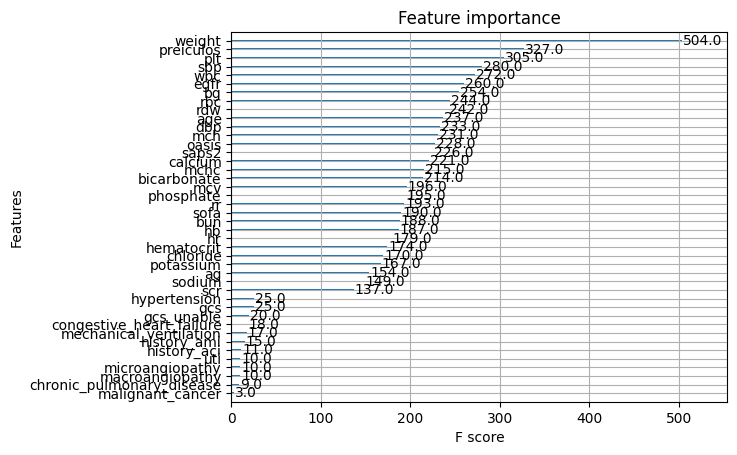

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

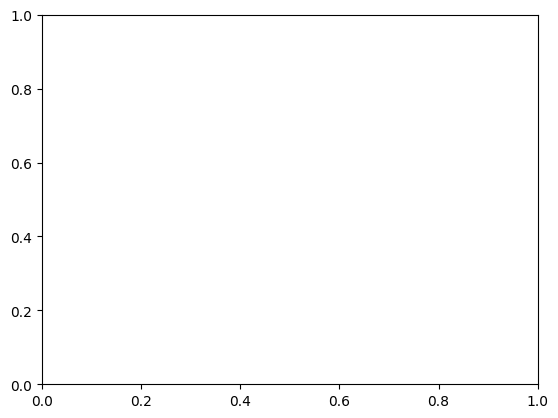

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))



[0]	validation_0-logloss:0.66671


[1]	validation_0-logloss:0.66384


[2]	validation_0-logloss:0.66188


[3]	validation_0-logloss:0.65977


[4]	validation_0-logloss:0.65742


[5]	validation_0-logloss:0.65518


[6]	validation_0-logloss:0.65324


[7]	validation_0-logloss:0.65020


[8]	validation_0-logloss:0.64766


[9]	validation_0-logloss:0.64520


[10]	validation_0-logloss:0.64268


[11]	validation_0-logloss:0.64035


[12]	validation_0-logloss:0.63859


[13]	validation_0-logloss:0.63710


[14]	validation_0-logloss:0.63505


[15]	validation_0-logloss:0.63238


[16]	validation_0-logloss:0.63029


[17]	validation_0-logloss:0.62835


[18]	validation_0-logloss:0.62675


[19]	validation_0-logloss:0.62484


[20]	validation_0-logloss:0.62316


[21]	validation_0-logloss:0.62149


[22]	validation_0-logloss:0.62019


[23]	validation_0-logloss:0.61928


[24]	validation_0-logloss:0.61739


[25]	validation_0-logloss:0.61517


[26]	validation_0-logloss:0.61388


[27]	validation_0-logloss:0.61230


[28]	validation_0-logloss:0.61114


[29]	validation_0-logloss:0.60919


[30]	validation_0-logloss:0.60783


[31]	validation_0-logloss:0.60691


[32]	validation_0-logloss:0.60593


[33]	validation_0-logloss:0.60468


[34]	validation_0-logloss:0.60347


[35]	validation_0-logloss:0.60203


[36]	validation_0-logloss:0.60036


[37]	validation_0-logloss:0.59921


[38]	validation_0-logloss:0.59812


[39]	validation_0-logloss:0.59713


[40]	validation_0-logloss:0.59567


[41]	validation_0-logloss:0.59519


[42]	validation_0-logloss:0.59351


[43]	validation_0-logloss:0.59230


[44]	validation_0-logloss:0.59085


[45]	validation_0-logloss:0.58941


[46]	validation_0-logloss:0.58833


[47]	validation_0-logloss:0.58679


[48]	validation_0-logloss:0.58581


[49]	validation_0-logloss:0.58464


[50]	validation_0-logloss:0.58393


[51]	validation_0-logloss:0.58271


[52]	validation_0-logloss:0.58170


[53]	validation_0-logloss:0.58052


[54]	validation_0-logloss:0.57936


[55]	validation_0-logloss:0.57806


[56]	validation_0-logloss:0.57706


[57]	validation_0-logloss:0.57637


[58]	validation_0-logloss:0.57522


[59]	validation_0-logloss:0.57450


[60]	validation_0-logloss:0.57354


[61]	validation_0-logloss:0.57246


[62]	validation_0-logloss:0.57122


[63]	validation_0-logloss:0.57046


[64]	validation_0-logloss:0.56943


[65]	validation_0-logloss:0.56843


[66]	validation_0-logloss:0.56755


[67]	validation_0-logloss:0.56659


[68]	validation_0-logloss:0.56577


[69]	validation_0-logloss:0.56532


[70]	validation_0-logloss:0.56460


[71]	validation_0-logloss:0.56397


[72]	validation_0-logloss:0.56290


[73]	validation_0-logloss:0.56176


[74]	validation_0-logloss:0.56074


[75]	validation_0-logloss:0.56073


[76]	validation_0-logloss:0.56022


[77]	validation_0-logloss:0.55926


[78]	validation_0-logloss:0.55839


[79]	validation_0-logloss:0.55783


[80]	validation_0-logloss:0.55715


[81]	validation_0-logloss:0.55634


[82]	validation_0-logloss:0.55565


[83]	validation_0-logloss:0.55504


[84]	validation_0-logloss:0.55425


[85]	validation_0-logloss:0.55377


[86]	validation_0-logloss:0.55334


[87]	validation_0-logloss:0.55250


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:23:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[88]	validation_0-logloss:0.55179


[89]	validation_0-logloss:0.55095


[90]	validation_0-logloss:0.55038


[91]	validation_0-logloss:0.54978


[92]	validation_0-logloss:0.54935


[93]	validation_0-logloss:0.54898


[94]	validation_0-logloss:0.54830


[95]	validation_0-logloss:0.54743


[96]	validation_0-logloss:0.54636


[97]	validation_0-logloss:0.54572


[98]	validation_0-logloss:0.54515


[99]	validation_0-logloss:0.54458


[100]	validation_0-logloss:0.54404


[101]	validation_0-logloss:0.54377


[102]	validation_0-logloss:0.54341


[103]	validation_0-logloss:0.54272


[104]	validation_0-logloss:0.54236


[105]	validation_0-logloss:0.54152


[106]	validation_0-logloss:0.54089


[107]	validation_0-logloss:0.54008


[108]	validation_0-logloss:0.53957


[109]	validation_0-logloss:0.53904


[110]	validation_0-logloss:0.53889


[111]	validation_0-logloss:0.53822


[112]	validation_0-logloss:0.53760


[113]	validation_0-logloss:0.53736


[114]	validation_0-logloss:0.53698


[115]	validation_0-logloss:0.53691


[116]	validation_0-logloss:0.53665


[117]	validation_0-logloss:0.53632


[118]	validation_0-logloss:0.53599


[119]	validation_0-logloss:0.53563


[120]	validation_0-logloss:0.53530


[121]	validation_0-logloss:0.53516


[122]	validation_0-logloss:0.53504

[123]	validation_0-logloss:0.53464


[124]	validation_0-logloss:0.53392


[125]	validation_0-logloss:0.53304


[126]	validation_0-logloss:0.53250


[127]	validation_0-logloss:0.53208


[128]	validation_0-logloss:0.53212


[129]	validation_0-logloss:0.53190


[130]	validation_0-logloss:0.53103


[131]	validation_0-logloss:0.53058


[132]	validation_0-logloss:0.53011


[133]	validation_0-logloss:0.52954


[134]	validation_0-logloss:0.52954


[135]	validation_0-logloss:0.52956


[136]	validation_0-logloss:0.52958


[137]	validation_0-logloss:0.52894


[138]	validation_0-logloss:0.52830


[139]	validation_0-logloss:0.52782


[140]	validation_0-logloss:0.52756


[141]	validation_0-logloss:0.52740


[142]	validation_0-logloss:0.52675


[143]	validation_0-logloss:0.52613


[144]	validation_0-logloss:0.52614


[145]	validation_0-logloss:0.52565


[146]	validation_0-logloss:0.52520


[147]	validation_0-logloss:0.52477


[148]	validation_0-logloss:0.52456

[149]	validation_0-logloss:0.52425


[150]	validation_0-logloss:0.52406


[151]	validation_0-logloss:0.52374


[152]	validation_0-logloss:0.52338


[153]	validation_0-logloss:0.52299


[154]	validation_0-logloss:0.52290


[155]	validation_0-logloss:0.52250


[156]	validation_0-logloss:0.52254


[157]	validation_0-logloss:0.52226


[158]	validation_0-logloss:0.52175


[159]	validation_0-logloss:0.52121


[160]	validation_0-logloss:0.52079


[161]	validation_0-logloss:0.52045


[162]	validation_0-logloss:0.52015


[163]	validation_0-logloss:0.51979


[164]	validation_0-logloss:0.51962


[165]	validation_0-logloss:0.51923


[166]	validation_0-logloss:0.51900


[167]	validation_0-logloss:0.51890


[168]	validation_0-logloss:0.51864


[169]	validation_0-logloss:0.51863


[170]	validation_0-logloss:0.51846


[171]	validation_0-logloss:0.51834


[172]	validation_0-logloss:0.51820


[173]	validation_0-logloss:0.51799


[174]	validation_0-logloss:0.51749


[175]	validation_0-logloss:0.51698


[176]	validation_0-logloss:0.51672


[177]	validation_0-logloss:0.51602


[178]	validation_0-logloss:0.51568


[179]	validation_0-logloss:0.51581


[180]	validation_0-logloss:0.51580


[181]	validation_0-logloss:0.51559


[182]	validation_0-logloss:0.51540


[183]	validation_0-logloss:0.51527


[184]	validation_0-logloss:0.51534


[185]	validation_0-logloss:0.51545


[186]	validation_0-logloss:0.51514


[187]	validation_0-logloss:0.51484


[188]	validation_0-logloss:0.51477


[189]	validation_0-logloss:0.51449


[190]	validation_0-logloss:0.51446


[191]	validation_0-logloss:0.51444


[192]	validation_0-logloss:0.51422


[193]	validation_0-logloss:0.51396


[194]	validation_0-logloss:0.51381


[195]	validation_0-logloss:0.51339


[196]	validation_0-logloss:0.51325


[197]	validation_0-logloss:0.51324


[198]	validation_0-logloss:0.51343


[199]	validation_0-logloss:0.51321


[200]	validation_0-logloss:0.51319


[201]	validation_0-logloss:0.51281


[202]	validation_0-logloss:0.51296


[203]	validation_0-logloss:0.51271


[204]	validation_0-logloss:0.51254


[205]	validation_0-logloss:0.51247


[206]	validation_0-logloss:0.51229


[207]	validation_0-logloss:0.51212


[208]	validation_0-logloss:0.51197


[209]	validation_0-logloss:0.51191


[210]	validation_0-logloss:0.51200


[211]	validation_0-logloss:0.51217


[212]	validation_0-logloss:0.51214


[213]	validation_0-logloss:0.51196


[214]	validation_0-logloss:0.51193


[215]	validation_0-logloss:0.51167


[216]	validation_0-logloss:0.51184


[217]	validation_0-logloss:0.51183


[218]	validation_0-logloss:0.51165


[219]	validation_0-logloss:0.51126


[220]	validation_0-logloss:0.51112


[221]	validation_0-logloss:0.51063


[222]	validation_0-logloss:0.51071


[223]	validation_0-logloss:0.51040


[224]	validation_0-logloss:0.51031


[225]	validation_0-logloss:0.51020


[226]	validation_0-logloss:0.50974


[227]	validation_0-logloss:0.50962


[228]	validation_0-logloss:0.50980


[229]	validation_0-logloss:0.50954


[230]	validation_0-logloss:0.50948


[231]	validation_0-logloss:0.50930


[232]	validation_0-logloss:0.50935


[233]	validation_0-logloss:0.50941


[234]	validation_0-logloss:0.50896


[235]	validation_0-logloss:0.50907


[236]	validation_0-logloss:0.50912


[237]	validation_0-logloss:0.50925


[238]	validation_0-logloss:0.50929


[239]	validation_0-logloss:0.50910


[240]	validation_0-logloss:0.50905


[241]	validation_0-logloss:0.50908


[242]	validation_0-logloss:0.50847


[243]	validation_0-logloss:0.50837


[244]	validation_0-logloss:0.50811


[245]	validation_0-logloss:0.50813


[246]	validation_0-logloss:0.50802


[247]	validation_0-logloss:0.50805


[248]	validation_0-logloss:0.50789


[249]	validation_0-logloss:0.50796


[250]	validation_0-logloss:0.50758


[251]	validation_0-logloss:0.50767


[252]	validation_0-logloss:0.50738


[253]	validation_0-logloss:0.50742


[254]	validation_0-logloss:0.50728


[255]	validation_0-logloss:0.50721


[256]	validation_0-logloss:0.50719


[257]	validation_0-logloss:0.50716


[258]	validation_0-logloss:0.50721


[259]	validation_0-logloss:0.50714


[260]	validation_0-logloss:0.50712


[261]	validation_0-logloss:0.50727


[262]	validation_0-logloss:0.50698


[263]	validation_0-logloss:0.50718


[264]	validation_0-logloss:0.50714


[265]	validation_0-logloss:0.50712


[266]	validation_0-logloss:0.50717


[267]	validation_0-logloss:0.50749


[268]	validation_0-logloss:0.50729


[269]	validation_0-logloss:0.50721


[270]	validation_0-logloss:0.50708


[271]	validation_0-logloss:0.50703


[272]	validation_0-logloss:0.50661


[273]	validation_0-logloss:0.50629


[274]	validation_0-logloss:0.50598


[275]	validation_0-logloss:0.50568


[276]	validation_0-logloss:0.50564


[277]	validation_0-logloss:0.50559


[278]	validation_0-logloss:0.50562


[279]	validation_0-logloss:0.50568


[280]	validation_0-logloss:0.50575


[281]	validation_0-logloss:0.50555


[282]	validation_0-logloss:0.50549


[283]	validation_0-logloss:0.50570


[284]	validation_0-logloss:0.50595


[285]	validation_0-logloss:0.50577


[286]	validation_0-logloss:0.50597


[287]	validation_0-logloss:0.50605


[288]	validation_0-logloss:0.50570


[289]	validation_0-logloss:0.50564


[290]	validation_0-logloss:0.50573


[291]	validation_0-logloss:0.50554


[292]	validation_0-logloss:0.50547


[293]	validation_0-logloss:0.50522


[294]	validation_0-logloss:0.50511


[295]	validation_0-logloss:0.50539


[296]	validation_0-logloss:0.50523


[297]	validation_0-logloss:0.50507

[298]	validation_0-logloss:0.50497


[299]	validation_0-logloss:0.50487


[300]	validation_0-logloss:0.50466


[301]	validation_0-logloss:0.50431


[302]	validation_0-logloss:0.50437


[303]	validation_0-logloss:0.50427


[304]	validation_0-logloss:0.50412


[305]	validation_0-logloss:0.50394


[306]	validation_0-logloss:0.50390


[307]	validation_0-logloss:0.50345


[308]	validation_0-logloss:0.50354


[309]	validation_0-logloss:0.50314


[310]	validation_0-logloss:0.50312


[311]	validation_0-logloss:0.50283


[312]	validation_0-logloss:0.50293


[313]	validation_0-logloss:0.50291


[314]	validation_0-logloss:0.50271


[315]	validation_0-logloss:0.50244


[316]	validation_0-logloss:0.50252


[317]	validation_0-logloss:0.50228


[318]	validation_0-logloss:0.50224


[319]	validation_0-logloss:0.50249


[320]	validation_0-logloss:0.50262


[321]	validation_0-logloss:0.50257


[322]	validation_0-logloss:0.50236


[323]	validation_0-logloss:0.50216


[324]	validation_0-logloss:0.50215

[325]	validation_0-logloss:0.50222


[326]	validation_0-logloss:0.50217


[327]	validation_0-logloss:0.50197


[328]	validation_0-logloss:0.50178


[329]	validation_0-logloss:0.50211


[330]	validation_0-logloss:0.50174


[331]	validation_0-logloss:0.50182


[332]	validation_0-logloss:0.50204


[333]	validation_0-logloss:0.50195


[334]	validation_0-logloss:0.50191


[335]	validation_0-logloss:0.50184


[336]	validation_0-logloss:0.50187


[337]	validation_0-logloss:0.50183


[338]	validation_0-logloss:0.50204


[339]	validation_0-logloss:0.50216


[0]	validation_0-logloss:0.66752


[1]	validation_0-logloss:0.66542


[2]	validation_0-logloss:0.66299


[3]	validation_0-logloss:0.66047


[4]	validation_0-logloss:0.65788


[5]	validation_0-logloss:0.65526


[6]	validation_0-logloss:0.65246


[7]	validation_0-logloss:0.65054


[8]	validation_0-logloss:0.64828


[9]	validation_0-logloss:0.64602


[10]	validation_0-logloss:0.64430


[11]	validation_0-logloss:0.64241


[12]	validation_0-logloss:0.64094


[13]	validation_0-logloss:0.63935


[14]	validation_0-logloss:0.63679


[15]	validation_0-logloss:0.63467


[16]	validation_0-logloss:0.63322


[17]	validation_0-logloss:0.63147


[18]	validation_0-logloss:0.62979


[19]	validation_0-logloss:0.62827


[20]	validation_0-logloss:0.62594


[21]	validation_0-logloss:0.62396


[22]	validation_0-logloss:0.62268


[23]	validation_0-logloss:0.62093


[24]	validation_0-logloss:0.61944


[25]	validation_0-logloss:0.61736


[26]	validation_0-logloss:0.61631


[27]	validation_0-logloss:0.61421


[28]	validation_0-logloss:0.61255


[29]	validation_0-logloss:0.61108


[30]	validation_0-logloss:0.60992


[31]	validation_0-logloss:0.60861


[32]	validation_0-logloss:0.60750


[33]	validation_0-logloss:0.60657


[34]	validation_0-logloss:0.60493


[35]	validation_0-logloss:0.60375


[36]	validation_0-logloss:0.60243


[37]	validation_0-logloss:0.60113


[38]	validation_0-logloss:0.59966


[39]	validation_0-logloss:0.59815


[40]	validation_0-logloss:0.59671


[41]	validation_0-logloss:0.59477


[42]	validation_0-logloss:0.59350


[43]	validation_0-logloss:0.59254


[44]	validation_0-logloss:0.59113


[45]	validation_0-logloss:0.58996


[46]	validation_0-logloss:0.58831


[47]	validation_0-logloss:0.58762


[48]	validation_0-logloss:0.58618


[49]	validation_0-logloss:0.58537


[50]	validation_0-logloss:0.58410


[51]	validation_0-logloss:0.58300


[52]	validation_0-logloss:0.58179


[53]	validation_0-logloss:0.58104


[54]	validation_0-logloss:0.57970


[55]	validation_0-logloss:0.57885


[56]	validation_0-logloss:0.57813


[57]	validation_0-logloss:0.57719


[58]	validation_0-logloss:0.57641


[59]	validation_0-logloss:0.57540


[60]	validation_0-logloss:0.57478


[61]	validation_0-logloss:0.57419


[62]	validation_0-logloss:0.57348


[63]	validation_0-logloss:0.57272


[64]	validation_0-logloss:0.57217


[65]	validation_0-logloss:0.57131


[66]	validation_0-logloss:0.57002


[67]	validation_0-logloss:0.56883


[68]	validation_0-logloss:0.56766


[69]	validation_0-logloss:0.56642


[70]	validation_0-logloss:0.56532


[71]	validation_0-logloss:0.56476


[72]	validation_0-logloss:0.56373


[73]	validation_0-logloss:0.56320


[74]	validation_0-logloss:0.56220


[75]	validation_0-logloss:0.56131


[76]	validation_0-logloss:0.56065


[77]	validation_0-logloss:0.55971


[78]	validation_0-logloss:0.55911


[79]	validation_0-logloss:0.55797


[80]	validation_0-logloss:0.55716


[81]	validation_0-logloss:0.55650


[82]	validation_0-logloss:0.55579


[83]	validation_0-logloss:0.55474


[84]	validation_0-logloss:0.55398


[85]	validation_0-logloss:0.55355


[86]	validation_0-logloss:0.55311


[87]	validation_0-logloss:0.55273


[88]	validation_0-logloss:0.55207


[89]	validation_0-logloss:0.55172


[90]	validation_0-logloss:0.55112


[91]	validation_0-logloss:0.55059


[92]	validation_0-logloss:0.55050


[93]	validation_0-logloss:0.55002


[94]	validation_0-logloss:0.54918


[95]	validation_0-logloss:0.54908


[96]	validation_0-logloss:0.54863


[97]	validation_0-logloss:0.54815


[98]	validation_0-logloss:0.54730


[99]	validation_0-logloss:0.54665


[100]	validation_0-logloss:0.54606


[101]	validation_0-logloss:0.54542


[102]	validation_0-logloss:0.54517


[103]	validation_0-logloss:0.54434


[104]	validation_0-logloss:0.54411


[105]	validation_0-logloss:0.54347


[106]	validation_0-logloss:0.54322


[107]	validation_0-logloss:0.54294


[108]	validation_0-logloss:0.54243


[109]	validation_0-logloss:0.54187


[110]	validation_0-logloss:0.54151


[111]	validation_0-logloss:0.54129


[112]	validation_0-logloss:0.54085


[113]	validation_0-logloss:0.54058


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:23:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[114]	validation_0-logloss:0.53982


[115]	validation_0-logloss:0.53940


[116]	validation_0-logloss:0.53913


[117]	validation_0-logloss:0.53837


[118]	validation_0-logloss:0.53786


[119]	validation_0-logloss:0.53759


[120]	validation_0-logloss:0.53696


[121]	validation_0-logloss:0.53666


[122]	validation_0-logloss:0.53627


[123]	validation_0-logloss:0.53616


[124]	validation_0-logloss:0.53567


[125]	validation_0-logloss:0.53527


[126]	validation_0-logloss:0.53502


[127]	validation_0-logloss:0.53462


[128]	validation_0-logloss:0.53428


[129]	validation_0-logloss:0.53396


[130]	validation_0-logloss:0.53361


[131]	validation_0-logloss:0.53328


[132]	validation_0-logloss:0.53330


[133]	validation_0-logloss:0.53291


[134]	validation_0-logloss:0.53248


[135]	validation_0-logloss:0.53209


[136]	validation_0-logloss:0.53178


[137]	validation_0-logloss:0.53159


[138]	validation_0-logloss:0.53130


[139]	validation_0-logloss:0.53095


[140]	validation_0-logloss:0.53088


[141]	validation_0-logloss:0.53061


[142]	validation_0-logloss:0.53041


[143]	validation_0-logloss:0.53013


[144]	validation_0-logloss:0.52985


[145]	validation_0-logloss:0.53016


[146]	validation_0-logloss:0.52988


[147]	validation_0-logloss:0.52966


[148]	validation_0-logloss:0.52925


[149]	validation_0-logloss:0.52918


[150]	validation_0-logloss:0.52870


[151]	validation_0-logloss:0.52843


[152]	validation_0-logloss:0.52811


[153]	validation_0-logloss:0.52783


[154]	validation_0-logloss:0.52769


[155]	validation_0-logloss:0.52724


[156]	validation_0-logloss:0.52679


[157]	validation_0-logloss:0.52653


[158]	validation_0-logloss:0.52598


[159]	validation_0-logloss:0.52602


[160]	validation_0-logloss:0.52609


[161]	validation_0-logloss:0.52559


[162]	validation_0-logloss:0.52521


[163]	validation_0-logloss:0.52492


[164]	validation_0-logloss:0.52444


[165]	validation_0-logloss:0.52435


[166]	validation_0-logloss:0.52400


[167]	validation_0-logloss:0.52389


[168]	validation_0-logloss:0.52375

[169]	validation_0-logloss:0.52364


[170]	validation_0-logloss:0.52326


[171]	validation_0-logloss:0.52318


[172]	validation_0-logloss:0.52278


[173]	validation_0-logloss:0.52231


[174]	validation_0-logloss:0.52200


[175]	validation_0-logloss:0.52150


[176]	validation_0-logloss:0.52152


[177]	validation_0-logloss:0.52144


[178]	validation_0-logloss:0.52138


[179]	validation_0-logloss:0.52114


[180]	validation_0-logloss:0.52109


[181]	validation_0-logloss:0.52088


[182]	validation_0-logloss:0.52061


[183]	validation_0-logloss:0.52037


[184]	validation_0-logloss:0.52026


[185]	validation_0-logloss:0.52035

[186]	validation_0-logloss:0.52015


[187]	validation_0-logloss:0.52020


[188]	validation_0-logloss:0.52035


[189]	validation_0-logloss:0.52023


[190]	validation_0-logloss:0.51999


[191]	validation_0-logloss:0.51958


[192]	validation_0-logloss:0.51927


[193]	validation_0-logloss:0.51898


[194]	validation_0-logloss:0.51858


[195]	validation_0-logloss:0.51844


[196]	validation_0-logloss:0.51852


[197]	validation_0-logloss:0.51834

[198]	validation_0-logloss:0.51848


[199]	validation_0-logloss:0.51826


[200]	validation_0-logloss:0.51809


[201]	validation_0-logloss:0.51814


[202]	validation_0-logloss:0.51812


[203]	validation_0-logloss:0.51822


[204]	validation_0-logloss:0.51778


[205]	validation_0-logloss:0.51771


[206]	validation_0-logloss:0.51734


[207]	validation_0-logloss:0.51710


[208]	validation_0-logloss:0.51701


[209]	validation_0-logloss:0.51694


[210]	validation_0-logloss:0.51697


[211]	validation_0-logloss:0.51701


[212]	validation_0-logloss:0.51649


[213]	validation_0-logloss:0.51645


[214]	validation_0-logloss:0.51632


[215]	validation_0-logloss:0.51612


[216]	validation_0-logloss:0.51612


[217]	validation_0-logloss:0.51609


[218]	validation_0-logloss:0.51597


[219]	validation_0-logloss:0.51583


[220]	validation_0-logloss:0.51556


[221]	validation_0-logloss:0.51509


[222]	validation_0-logloss:0.51499


[223]	validation_0-logloss:0.51490


[224]	validation_0-logloss:0.51484


[225]	validation_0-logloss:0.51473


[226]	validation_0-logloss:0.51482


[227]	validation_0-logloss:0.51494


[228]	validation_0-logloss:0.51477


[229]	validation_0-logloss:0.51471


[230]	validation_0-logloss:0.51454


[231]	validation_0-logloss:0.51449


[232]	validation_0-logloss:0.51429


[233]	validation_0-logloss:0.51433


[234]	validation_0-logloss:0.51451


[235]	validation_0-logloss:0.51442


[236]	validation_0-logloss:0.51406


[237]	validation_0-logloss:0.51414


[238]	validation_0-logloss:0.51422


[239]	validation_0-logloss:0.51432


[240]	validation_0-logloss:0.51400


[241]	validation_0-logloss:0.51408


[242]	validation_0-logloss:0.51387


[243]	validation_0-logloss:0.51361


[244]	validation_0-logloss:0.51346


[245]	validation_0-logloss:0.51369


[246]	validation_0-logloss:0.51336


[247]	validation_0-logloss:0.51338


[248]	validation_0-logloss:0.51338


[249]	validation_0-logloss:0.51309


[250]	validation_0-logloss:0.51293


[251]	validation_0-logloss:0.51294


[252]	validation_0-logloss:0.51306


[253]	validation_0-logloss:0.51318


[254]	validation_0-logloss:0.51276


[255]	validation_0-logloss:0.51263


[256]	validation_0-logloss:0.51236


[257]	validation_0-logloss:0.51231


[258]	validation_0-logloss:0.51216


[259]	validation_0-logloss:0.51196


[260]	validation_0-logloss:0.51160


[261]	validation_0-logloss:0.51154


[262]	validation_0-logloss:0.51167


[263]	validation_0-logloss:0.51149


[264]	validation_0-logloss:0.51179


[265]	validation_0-logloss:0.51173


[266]	validation_0-logloss:0.51183


[267]	validation_0-logloss:0.51191


[268]	validation_0-logloss:0.51184


[269]	validation_0-logloss:0.51171


[270]	validation_0-logloss:0.51165

[271]	validation_0-logloss:0.51160


[272]	validation_0-logloss:0.51148

[273]	validation_0-logloss:0.51120


[274]	validation_0-logloss:0.51105


[275]	validation_0-logloss:0.51072


[276]	validation_0-logloss:0.51107


[277]	validation_0-logloss:0.51092


[278]	validation_0-logloss:0.51131


[279]	validation_0-logloss:0.51155


[280]	validation_0-logloss:0.51147


[281]	validation_0-logloss:0.51175


[282]	validation_0-logloss:0.51171


[283]	validation_0-logloss:0.51178


[284]	validation_0-logloss:0.51172


[285]	validation_0-logloss:0.51174


[0]	validation_0-logloss:0.66827


[1]	validation_0-logloss:0.66580


[2]	validation_0-logloss:0.66398


[3]	validation_0-logloss:0.66165


[4]	validation_0-logloss:0.65953


[5]	validation_0-logloss:0.65776


[6]	validation_0-logloss:0.65647


[7]	validation_0-logloss:0.65418


[8]	validation_0-logloss:0.65201


[9]	validation_0-logloss:0.65037


[10]	validation_0-logloss:0.64916


[11]	validation_0-logloss:0.64761


[12]	validation_0-logloss:0.64614


[13]	validation_0-logloss:0.64447


[14]	validation_0-logloss:0.64294


[15]	validation_0-logloss:0.64082


[16]	validation_0-logloss:0.63980


[17]	validation_0-logloss:0.63804


[18]	validation_0-logloss:0.63687


[19]	validation_0-logloss:0.63527


[20]	validation_0-logloss:0.63367


[21]	validation_0-logloss:0.63250


[22]	validation_0-logloss:0.63125


[23]	validation_0-logloss:0.62983


[24]	validation_0-logloss:0.62851


[25]	validation_0-logloss:0.62729


[26]	validation_0-logloss:0.62564


[27]	validation_0-logloss:0.62453


[28]	validation_0-logloss:0.62360


[29]	validation_0-logloss:0.62268


[30]	validation_0-logloss:0.62159


[31]	validation_0-logloss:0.62114


[32]	validation_0-logloss:0.61958


[33]	validation_0-logloss:0.61843


[34]	validation_0-logloss:0.61809


[35]	validation_0-logloss:0.61694


[36]	validation_0-logloss:0.61580


[37]	validation_0-logloss:0.61477


[38]	validation_0-logloss:0.61431


[39]	validation_0-logloss:0.61318


[40]	validation_0-logloss:0.61225


[41]	validation_0-logloss:0.61104


[42]	validation_0-logloss:0.60978


[43]	validation_0-logloss:0.60838


[44]	validation_0-logloss:0.60711


[45]	validation_0-logloss:0.60617


[46]	validation_0-logloss:0.60518


[47]	validation_0-logloss:0.60437


[48]	validation_0-logloss:0.60386


[49]	validation_0-logloss:0.60307


[50]	validation_0-logloss:0.60221


[51]	validation_0-logloss:0.60114


[52]	validation_0-logloss:0.60050


[53]	validation_0-logloss:0.59960


[54]	validation_0-logloss:0.59884


[55]	validation_0-logloss:0.59792


[56]	validation_0-logloss:0.59693


[57]	validation_0-logloss:0.59612


[58]	validation_0-logloss:0.59562


[59]	validation_0-logloss:0.59527


[60]	validation_0-logloss:0.59445


[61]	validation_0-logloss:0.59396


[62]	validation_0-logloss:0.59285


[63]	validation_0-logloss:0.59187


[64]	validation_0-logloss:0.59125


[65]	validation_0-logloss:0.59054


[66]	validation_0-logloss:0.58982


[67]	validation_0-logloss:0.58931


[68]	validation_0-logloss:0.58861


[69]	validation_0-logloss:0.58781


[70]	validation_0-logloss:0.58678


[71]	validation_0-logloss:0.58669


[72]	validation_0-logloss:0.58618


[73]	validation_0-logloss:0.58572


[74]	validation_0-logloss:0.58473


[75]	validation_0-logloss:0.58423


[76]	validation_0-logloss:0.58364


[77]	validation_0-logloss:0.58294


[78]	validation_0-logloss:0.58217


[79]	validation_0-logloss:0.58203


[80]	validation_0-logloss:0.58134


[81]	validation_0-logloss:0.58082


[82]	validation_0-logloss:0.58014


[83]	validation_0-logloss:0.57955


[84]	validation_0-logloss:0.57881


[85]	validation_0-logloss:0.57831


[86]	validation_0-logloss:0.57769


[87]	validation_0-logloss:0.57704


[88]	validation_0-logloss:0.57616


[89]	validation_0-logloss:0.57623


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:23:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[90]	validation_0-logloss:0.57597


[91]	validation_0-logloss:0.57578


[92]	validation_0-logloss:0.57482


[93]	validation_0-logloss:0.57445


[94]	validation_0-logloss:0.57382


[95]	validation_0-logloss:0.57365


[96]	validation_0-logloss:0.57304


[97]	validation_0-logloss:0.57287


[98]	validation_0-logloss:0.57260


[99]	validation_0-logloss:0.57210


[100]	validation_0-logloss:0.57183


[101]	validation_0-logloss:0.57173


[102]	validation_0-logloss:0.57161


[103]	validation_0-logloss:0.57105


[104]	validation_0-logloss:0.57038


[105]	validation_0-logloss:0.56971


[106]	validation_0-logloss:0.56940


[107]	validation_0-logloss:0.56927


[108]	validation_0-logloss:0.56878


[109]	validation_0-logloss:0.56838


[110]	validation_0-logloss:0.56816


[111]	validation_0-logloss:0.56793


[112]	validation_0-logloss:0.56748


[113]	validation_0-logloss:0.56698


[114]	validation_0-logloss:0.56635


[115]	validation_0-logloss:0.56596


[116]	validation_0-logloss:0.56579


[117]	validation_0-logloss:0.56528


[118]	validation_0-logloss:0.56459


[119]	validation_0-logloss:0.56374


[120]	validation_0-logloss:0.56364


[121]	validation_0-logloss:0.56372


[122]	validation_0-logloss:0.56344


[123]	validation_0-logloss:0.56338


[124]	validation_0-logloss:0.56318


[125]	validation_0-logloss:0.56264


[126]	validation_0-logloss:0.56233


[127]	validation_0-logloss:0.56238


[128]	validation_0-logloss:0.56227


[129]	validation_0-logloss:0.56203


[130]	validation_0-logloss:0.56161


[131]	validation_0-logloss:0.56147


[132]	validation_0-logloss:0.56119


[133]	validation_0-logloss:0.56075


[134]	validation_0-logloss:0.56066


[135]	validation_0-logloss:0.56026


[136]	validation_0-logloss:0.56039


[137]	validation_0-logloss:0.56010


[138]	validation_0-logloss:0.55961


[139]	validation_0-logloss:0.55990


[140]	validation_0-logloss:0.55964


[141]	validation_0-logloss:0.55977


[142]	validation_0-logloss:0.55958


[143]	validation_0-logloss:0.55918


[144]	validation_0-logloss:0.55935


[145]	validation_0-logloss:0.55944


[146]	validation_0-logloss:0.55863


[147]	validation_0-logloss:0.55877


[148]	validation_0-logloss:0.55838


[149]	validation_0-logloss:0.55827


[150]	validation_0-logloss:0.55807


[151]	validation_0-logloss:0.55814


[152]	validation_0-logloss:0.55805


[153]	validation_0-logloss:0.55800


[154]	validation_0-logloss:0.55784


[155]	validation_0-logloss:0.55740


[156]	validation_0-logloss:0.55761


[157]	validation_0-logloss:0.55739


[158]	validation_0-logloss:0.55729


[159]	validation_0-logloss:0.55686


[160]	validation_0-logloss:0.55656


[161]	validation_0-logloss:0.55678


[162]	validation_0-logloss:0.55673


[163]	validation_0-logloss:0.55682


[164]	validation_0-logloss:0.55598


[165]	validation_0-logloss:0.55593


[166]	validation_0-logloss:0.55601


[167]	validation_0-logloss:0.55569


[168]	validation_0-logloss:0.55566


[169]	validation_0-logloss:0.55527


[170]	validation_0-logloss:0.55554


[171]	validation_0-logloss:0.55546


[172]	validation_0-logloss:0.55532


[173]	validation_0-logloss:0.55515


[174]	validation_0-logloss:0.55540


[175]	validation_0-logloss:0.55520


[176]	validation_0-logloss:0.55524


[177]	validation_0-logloss:0.55529


[178]	validation_0-logloss:0.55537


[179]	validation_0-logloss:0.55525


[180]	validation_0-logloss:0.55511


[181]	validation_0-logloss:0.55498


[182]	validation_0-logloss:0.55477


[183]	validation_0-logloss:0.55486


[184]	validation_0-logloss:0.55462


[185]	validation_0-logloss:0.55449


[186]	validation_0-logloss:0.55448


[187]	validation_0-logloss:0.55455


[188]	validation_0-logloss:0.55454


[189]	validation_0-logloss:0.55441


[190]	validation_0-logloss:0.55400


[191]	validation_0-logloss:0.55380


[192]	validation_0-logloss:0.55359


[193]	validation_0-logloss:0.55354


[194]	validation_0-logloss:0.55324


[195]	validation_0-logloss:0.55304


[196]	validation_0-logloss:0.55292


[197]	validation_0-logloss:0.55300


[198]	validation_0-logloss:0.55303


[199]	validation_0-logloss:0.55314


[200]	validation_0-logloss:0.55322


[201]	validation_0-logloss:0.55322


[202]	validation_0-logloss:0.55323


[203]	validation_0-logloss:0.55331


[204]	validation_0-logloss:0.55327


[205]	validation_0-logloss:0.55335


[0]	validation_0-logloss:0.66770


[1]	validation_0-logloss:0.66542


[2]	validation_0-logloss:0.66364


[3]	validation_0-logloss:0.66237


[4]	validation_0-logloss:0.66030


[5]	validation_0-logloss:0.65795


[6]	validation_0-logloss:0.65648


[7]	validation_0-logloss:0.65528


[8]	validation_0-logloss:0.65297


[9]	validation_0-logloss:0.65139


[10]	validation_0-logloss:0.64975


[11]	validation_0-logloss:0.64782


[12]	validation_0-logloss:0.64614


[13]	validation_0-logloss:0.64453


[14]	validation_0-logloss:0.64292


[15]	validation_0-logloss:0.64145


[16]	validation_0-logloss:0.64010


[17]	validation_0-logloss:0.63800


[18]	validation_0-logloss:0.63631


[19]	validation_0-logloss:0.63531


[20]	validation_0-logloss:0.63358


[21]	validation_0-logloss:0.63255


[22]	validation_0-logloss:0.63077


[23]	validation_0-logloss:0.62922


[24]	validation_0-logloss:0.62758


[25]	validation_0-logloss:0.62592


[26]	validation_0-logloss:0.62481


[27]	validation_0-logloss:0.62339


[28]	validation_0-logloss:0.62156


[29]	validation_0-logloss:0.61992


[30]	validation_0-logloss:0.61836


[31]	validation_0-logloss:0.61679


[32]	validation_0-logloss:0.61580


[33]	validation_0-logloss:0.61434


[34]	validation_0-logloss:0.61283


[35]	validation_0-logloss:0.61150


[36]	validation_0-logloss:0.61050


[37]	validation_0-logloss:0.60942


[38]	validation_0-logloss:0.60863


[39]	validation_0-logloss:0.60741


[40]	validation_0-logloss:0.60679


[41]	validation_0-logloss:0.60607


[42]	validation_0-logloss:0.60469


[43]	validation_0-logloss:0.60356


[44]	validation_0-logloss:0.60246


[45]	validation_0-logloss:0.60126


[46]	validation_0-logloss:0.60040


[47]	validation_0-logloss:0.59924


[48]	validation_0-logloss:0.59829


[49]	validation_0-logloss:0.59744


[50]	validation_0-logloss:0.59658


[51]	validation_0-logloss:0.59553


[52]	validation_0-logloss:0.59441


[53]	validation_0-logloss:0.59302


[54]	validation_0-logloss:0.59178


[55]	validation_0-logloss:0.59057


[56]	validation_0-logloss:0.58977


[57]	validation_0-logloss:0.58881


[58]	validation_0-logloss:0.58797


[59]	validation_0-logloss:0.58721


[60]	validation_0-logloss:0.58604


[61]	validation_0-logloss:0.58492


[62]	validation_0-logloss:0.58380


[63]	validation_0-logloss:0.58281


[64]	validation_0-logloss:0.58235


[65]	validation_0-logloss:0.58119


[66]	validation_0-logloss:0.58085


[67]	validation_0-logloss:0.58035


[68]	validation_0-logloss:0.57949


[69]	validation_0-logloss:0.57919


[70]	validation_0-logloss:0.57845


[71]	validation_0-logloss:0.57800


[72]	validation_0-logloss:0.57721


[73]	validation_0-logloss:0.57651


[74]	validation_0-logloss:0.57576


[75]	validation_0-logloss:0.57547


[76]	validation_0-logloss:0.57522


[77]	validation_0-logloss:0.57438


[78]	validation_0-logloss:0.57304


[79]	validation_0-logloss:0.57242


[80]	validation_0-logloss:0.57180


[81]	validation_0-logloss:0.57104


[82]	validation_0-logloss:0.57052


[83]	validation_0-logloss:0.57026


[84]	validation_0-logloss:0.56977


[85]	validation_0-logloss:0.56900


[86]	validation_0-logloss:0.56839


[87]	validation_0-logloss:0.56785


[88]	validation_0-logloss:0.56684


[89]	validation_0-logloss:0.56620


[90]	validation_0-logloss:0.56607


[91]	validation_0-logloss:0.56579


[92]	validation_0-logloss:0.56529


[93]	validation_0-logloss:0.56493


[94]	validation_0-logloss:0.56436


[95]	validation_0-logloss:0.56411


[96]	validation_0-logloss:0.56345


[97]	validation_0-logloss:0.56311


[98]	validation_0-logloss:0.56315


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:23:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[99]	validation_0-logloss:0.56276


[100]	validation_0-logloss:0.56237


[101]	validation_0-logloss:0.56211


[102]	validation_0-logloss:0.56166


[103]	validation_0-logloss:0.56127


[104]	validation_0-logloss:0.56078


[105]	validation_0-logloss:0.56054


[106]	validation_0-logloss:0.56001


[107]	validation_0-logloss:0.55972


[108]	validation_0-logloss:0.55885


[109]	validation_0-logloss:0.55847


[110]	validation_0-logloss:0.55814


[111]	validation_0-logloss:0.55772


[112]	validation_0-logloss:0.55724

[113]	validation_0-logloss:0.55647


[114]	validation_0-logloss:0.55583

[115]	validation_0-logloss:0.55574


[116]	validation_0-logloss:0.55543


[117]	validation_0-logloss:0.55475


[118]	validation_0-logloss:0.55412


[119]	validation_0-logloss:0.55392

[120]	validation_0-logloss:0.55352


[121]	validation_0-logloss:0.55323


[122]	validation_0-logloss:0.55287


[123]	validation_0-logloss:0.55234


[124]	validation_0-logloss:0.55185


[125]	validation_0-logloss:0.55154


[126]	validation_0-logloss:0.55109


[127]	validation_0-logloss:0.55095


[128]	validation_0-logloss:0.55063


[129]	validation_0-logloss:0.55039


[130]	validation_0-logloss:0.55021


[131]	validation_0-logloss:0.55001


[132]	validation_0-logloss:0.54955


[133]	validation_0-logloss:0.54907


[134]	validation_0-logloss:0.54880


[135]	validation_0-logloss:0.54905


[136]	validation_0-logloss:0.54882


[137]	validation_0-logloss:0.54832


[138]	validation_0-logloss:0.54814


[139]	validation_0-logloss:0.54795


[140]	validation_0-logloss:0.54773


[141]	validation_0-logloss:0.54743

[142]	validation_0-logloss:0.54706


[143]	validation_0-logloss:0.54669


[144]	validation_0-logloss:0.54663


[145]	validation_0-logloss:0.54602


[146]	validation_0-logloss:0.54573


[147]	validation_0-logloss:0.54519


[148]	validation_0-logloss:0.54481


[149]	validation_0-logloss:0.54468


[150]	validation_0-logloss:0.54443


[151]	validation_0-logloss:0.54409


[152]	validation_0-logloss:0.54376


[153]	validation_0-logloss:0.54375


[154]	validation_0-logloss:0.54345


[155]	validation_0-logloss:0.54312


[156]	validation_0-logloss:0.54304


[157]	validation_0-logloss:0.54316


[158]	validation_0-logloss:0.54265


[159]	validation_0-logloss:0.54235


[160]	validation_0-logloss:0.54220


[161]	validation_0-logloss:0.54230


[162]	validation_0-logloss:0.54219


[163]	validation_0-logloss:0.54189


[164]	validation_0-logloss:0.54167


[165]	validation_0-logloss:0.54145


[166]	validation_0-logloss:0.54131

[167]	validation_0-logloss:0.54102

[168]	validation_0-logloss:0.54077


[169]	validation_0-logloss:0.54079


[170]	validation_0-logloss:0.54094

[171]	validation_0-logloss:0.54068


[172]	validation_0-logloss:0.54066


[173]	validation_0-logloss:0.54068


[174]	validation_0-logloss:0.54026


[175]	validation_0-logloss:0.54004


[176]	validation_0-logloss:0.53986


[177]	validation_0-logloss:0.53943


[178]	validation_0-logloss:0.53914


[179]	validation_0-logloss:0.53911


[180]	validation_0-logloss:0.53868


[181]	validation_0-logloss:0.53840


[182]	validation_0-logloss:0.53830


[183]	validation_0-logloss:0.53811


[184]	validation_0-logloss:0.53802


[185]	validation_0-logloss:0.53775


[186]	validation_0-logloss:0.53773


[187]	validation_0-logloss:0.53748


[188]	validation_0-logloss:0.53719


[189]	validation_0-logloss:0.53689


[190]	validation_0-logloss:0.53657


[191]	validation_0-logloss:0.53622


[192]	validation_0-logloss:0.53602

[193]	validation_0-logloss:0.53602


[194]	validation_0-logloss:0.53585


[195]	validation_0-logloss:0.53592


[196]	validation_0-logloss:0.53602


[197]	validation_0-logloss:0.53603


[198]	validation_0-logloss:0.53578


[199]	validation_0-logloss:0.53585


[200]	validation_0-logloss:0.53585

[201]	validation_0-logloss:0.53605


[202]	validation_0-logloss:0.53620


[203]	validation_0-logloss:0.53612


[204]	validation_0-logloss:0.53593


[205]	validation_0-logloss:0.53615


[206]	validation_0-logloss:0.53602


[207]	validation_0-logloss:0.53573


[208]	validation_0-logloss:0.53569

[209]	validation_0-logloss:0.53569


[210]	validation_0-logloss:0.53555


[211]	validation_0-logloss:0.53578


[212]	validation_0-logloss:0.53549


[213]	validation_0-logloss:0.53544


[214]	validation_0-logloss:0.53534


[215]	validation_0-logloss:0.53524


[216]	validation_0-logloss:0.53543


[217]	validation_0-logloss:0.53577


[218]	validation_0-logloss:0.53587


[219]	validation_0-logloss:0.53596

[220]	validation_0-logloss:0.53609


[221]	validation_0-logloss:0.53578


[222]	validation_0-logloss:0.53587


[223]	validation_0-logloss:0.53610


[224]	validation_0-logloss:0.53604


[0]	validation_0-logloss:0.66828


[1]	validation_0-logloss:0.66577


[2]	validation_0-logloss:0.66345


[3]	validation_0-logloss:0.66207


[4]	validation_0-logloss:0.66019


[5]	validation_0-logloss:0.65867


[6]	validation_0-logloss:0.65696


[7]	validation_0-logloss:0.65508


[8]	validation_0-logloss:0.65295


[9]	validation_0-logloss:0.65098


[10]	validation_0-logloss:0.64915


[11]	validation_0-logloss:0.64760


[12]	validation_0-logloss:0.64588


[13]	validation_0-logloss:0.64377


[14]	validation_0-logloss:0.64146


[15]	validation_0-logloss:0.63978


[16]	validation_0-logloss:0.63789


[17]	validation_0-logloss:0.63613


[18]	validation_0-logloss:0.63455


[19]	validation_0-logloss:0.63327


[20]	validation_0-logloss:0.63138


[21]	validation_0-logloss:0.63005


[22]	validation_0-logloss:0.62837


[23]	validation_0-logloss:0.62730


[24]	validation_0-logloss:0.62598


[25]	validation_0-logloss:0.62420


[26]	validation_0-logloss:0.62289


[27]	validation_0-logloss:0.62147


[28]	validation_0-logloss:0.61969


[29]	validation_0-logloss:0.61837


[30]	validation_0-logloss:0.61677


[31]	validation_0-logloss:0.61523


[32]	validation_0-logloss:0.61402


[33]	validation_0-logloss:0.61282


[34]	validation_0-logloss:0.61070


[35]	validation_0-logloss:0.60990


[36]	validation_0-logloss:0.60871


[37]	validation_0-logloss:0.60804


[38]	validation_0-logloss:0.60744


[39]	validation_0-logloss:0.60606


[40]	validation_0-logloss:0.60527


[41]	validation_0-logloss:0.60433


[42]	validation_0-logloss:0.60331


[43]	validation_0-logloss:0.60199


[44]	validation_0-logloss:0.60033


[45]	validation_0-logloss:0.59927


[46]	validation_0-logloss:0.59811


[47]	validation_0-logloss:0.59682


[48]	validation_0-logloss:0.59609


[49]	validation_0-logloss:0.59453


[50]	validation_0-logloss:0.59386


[51]	validation_0-logloss:0.59322


[52]	validation_0-logloss:0.59245


[53]	validation_0-logloss:0.59133


[54]	validation_0-logloss:0.59052


[55]	validation_0-logloss:0.58984


[56]	validation_0-logloss:0.58919


[57]	validation_0-logloss:0.58804


[58]	validation_0-logloss:0.58747


[59]	validation_0-logloss:0.58710


[60]	validation_0-logloss:0.58607


[61]	validation_0-logloss:0.58510


[62]	validation_0-logloss:0.58428


[63]	validation_0-logloss:0.58302


[64]	validation_0-logloss:0.58215


[65]	validation_0-logloss:0.58137


[66]	validation_0-logloss:0.58038


[67]	validation_0-logloss:0.57978


[68]	validation_0-logloss:0.57853


[69]	validation_0-logloss:0.57798


[70]	validation_0-logloss:0.57723


[71]	validation_0-logloss:0.57733


[72]	validation_0-logloss:0.57653


[73]	validation_0-logloss:0.57617


[74]	validation_0-logloss:0.57535


[75]	validation_0-logloss:0.57470


[76]	validation_0-logloss:0.57438


[77]	validation_0-logloss:0.57371


[78]	validation_0-logloss:0.57319


[79]	validation_0-logloss:0.57260


[80]	validation_0-logloss:0.57210


[81]	validation_0-logloss:0.57158


[82]	validation_0-logloss:0.57120


[83]	validation_0-logloss:0.57084


[84]	validation_0-logloss:0.57023


[85]	validation_0-logloss:0.57010


[86]	validation_0-logloss:0.56939


[87]	validation_0-logloss:0.56874


[88]	validation_0-logloss:0.56834


[89]	validation_0-logloss:0.56790


[90]	validation_0-logloss:0.56790


[91]	validation_0-logloss:0.56722


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:24:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[92]	validation_0-logloss:0.56651


[93]	validation_0-logloss:0.56596


[94]	validation_0-logloss:0.56579


[95]	validation_0-logloss:0.56578


[96]	validation_0-logloss:0.56511


[97]	validation_0-logloss:0.56467


[98]	validation_0-logloss:0.56425


[99]	validation_0-logloss:0.56412


[100]	validation_0-logloss:0.56387


[101]	validation_0-logloss:0.56316


[102]	validation_0-logloss:0.56319


[103]	validation_0-logloss:0.56283


[104]	validation_0-logloss:0.56204


[105]	validation_0-logloss:0.56156


[106]	validation_0-logloss:0.56089


[107]	validation_0-logloss:0.56093


[108]	validation_0-logloss:0.56024


[109]	validation_0-logloss:0.55994


[110]	validation_0-logloss:0.55937


[111]	validation_0-logloss:0.55875


[112]	validation_0-logloss:0.55840


[113]	validation_0-logloss:0.55810


[114]	validation_0-logloss:0.55786


[115]	validation_0-logloss:0.55780


[116]	validation_0-logloss:0.55695


[117]	validation_0-logloss:0.55676


[118]	validation_0-logloss:0.55648


[119]	validation_0-logloss:0.55637


[120]	validation_0-logloss:0.55654


[121]	validation_0-logloss:0.55632


[122]	validation_0-logloss:0.55629


[123]	validation_0-logloss:0.55593


[124]	validation_0-logloss:0.55571


[125]	validation_0-logloss:0.55542


[126]	validation_0-logloss:0.55483


[127]	validation_0-logloss:0.55439


[128]	validation_0-logloss:0.55404


[129]	validation_0-logloss:0.55352


[130]	validation_0-logloss:0.55339


[131]	validation_0-logloss:0.55312


[132]	validation_0-logloss:0.55284


[133]	validation_0-logloss:0.55242


[134]	validation_0-logloss:0.55208


[135]	validation_0-logloss:0.55196


[136]	validation_0-logloss:0.55185


[137]	validation_0-logloss:0.55140

[138]	validation_0-logloss:0.55093


[139]	validation_0-logloss:0.55073


[140]	validation_0-logloss:0.55084


[141]	validation_0-logloss:0.55041


[142]	validation_0-logloss:0.55063


[143]	validation_0-logloss:0.55054


[144]	validation_0-logloss:0.55038


[145]	validation_0-logloss:0.54989


[146]	validation_0-logloss:0.54953


[147]	validation_0-logloss:0.54928


[148]	validation_0-logloss:0.54867


[149]	validation_0-logloss:0.54797


[150]	validation_0-logloss:0.54756


[151]	validation_0-logloss:0.54757

[152]	validation_0-logloss:0.54731

[153]	validation_0-logloss:0.54715


[154]	validation_0-logloss:0.54672


[155]	validation_0-logloss:0.54661


[156]	validation_0-logloss:0.54638


[157]	validation_0-logloss:0.54646


[158]	validation_0-logloss:0.54658


[159]	validation_0-logloss:0.54629


[160]	validation_0-logloss:0.54583


[161]	validation_0-logloss:0.54569


[162]	validation_0-logloss:0.54575


[163]	validation_0-logloss:0.54554


[164]	validation_0-logloss:0.54546

[165]	validation_0-logloss:0.54467


[166]	validation_0-logloss:0.54441


[167]	validation_0-logloss:0.54448


[168]	validation_0-logloss:0.54451


[169]	validation_0-logloss:0.54460


[170]	validation_0-logloss:0.54425


[171]	validation_0-logloss:0.54384


[172]	validation_0-logloss:0.54405


[173]	validation_0-logloss:0.54385


[174]	validation_0-logloss:0.54397


[175]	validation_0-logloss:0.54363


[176]	validation_0-logloss:0.54351


[177]	validation_0-logloss:0.54369


[178]	validation_0-logloss:0.54366


[179]	validation_0-logloss:0.54361


[180]	validation_0-logloss:0.54360


[181]	validation_0-logloss:0.54337


[182]	validation_0-logloss:0.54289


[183]	validation_0-logloss:0.54278


[184]	validation_0-logloss:0.54225


[185]	validation_0-logloss:0.54198


[186]	validation_0-logloss:0.54198


[187]	validation_0-logloss:0.54182


[188]	validation_0-logloss:0.54170


[189]	validation_0-logloss:0.54168


[190]	validation_0-logloss:0.54156


[191]	validation_0-logloss:0.54125


[192]	validation_0-logloss:0.54141


[193]	validation_0-logloss:0.54133


[194]	validation_0-logloss:0.54123


[195]	validation_0-logloss:0.54122


[196]	validation_0-logloss:0.54105


[197]	validation_0-logloss:0.54098


[198]	validation_0-logloss:0.54104


[199]	validation_0-logloss:0.54075


[200]	validation_0-logloss:0.54104


[201]	validation_0-logloss:0.54134


[202]	validation_0-logloss:0.54147


[203]	validation_0-logloss:0.54159


[204]	validation_0-logloss:0.54177


[205]	validation_0-logloss:0.54168


[206]	validation_0-logloss:0.54188


[207]	validation_0-logloss:0.54164


[208]	validation_0-logloss:0.54160


[209]	validation_0-logloss:0.54144


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7905115914656525
Average Accuracy: 0.7379650903604129
Average Precision: 0.7028428078770544
Average Recall: 0.5823740201567749
